# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re

import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
%run "C:/users/eturk/Data_Science/Capstone_Project-Sentiment_Analysis/Data_Storytelling/contractions.py"

ERROR:root:File `'C:/users/eturk/Data_Science/Capstone_Project-Sentiment_Analysis/Data_Storytelling/contractions.py'` not found.


### Reading the Cleaned Dataset

In [29]:
# Read the file
df2 = pd.read_csv('cleaned_dataset.csv')

# Model Performance Improvements

## 1. Adding Most Common and Lest Common Words to Stopwords List

Since there were not too many distinguisher words in different classes, the most and least common 70 words added to the stopwords list and models were applied in order to see any changes in evaluation metrics.

**Words and Frequencies**

In [31]:
cleaned_text = [str(txt) for text in df2['clean_text'] for txt in text.split(' ') 
                if len(txt)>2 and txt not in 'not, nan']

word_dist = nltk.FreqDist(cleaned_text)

**Adding the Most Common and the Least Common 70 Words to the Stopwords List**

In [32]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/royalshoulders/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/royalshoulders/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
stopword_list= stopwords.words('english')

for y in word_dist.most_common()[-70:]:
    stopword_list.append(y[0])
    
mst_c = word_dist.most_common()[:70]

for x in mst_c:
    stopword_list.append(x[0])

In [34]:
print(len(stopword_list))

319


In [35]:
# Applying the new stopwords List to the Clean Text Column
lemmatizer = WordNetLemmatizer()

df2['clean_text'] = df2['clean_text'].map(lambda text: " ".join([lemmatizer.lemmatize(w) 
                                                               for w in text.split(' ') if w not in stopword_list]))

## Data Preparation

**Separating Response Variable and Feature**

In [36]:
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [37]:
# Splitting the Data Set into Train and Test Sets
X = df2['clean_text']
y = df2['rating_class']

**Splitting Dataset into Train and Test Set**

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [38]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Confusion Matrix Plot Function**

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.summer):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [40]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## Modeling (with CountVectorizer)

In [41]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

**Creating a function for applying different algorithms**

In [42]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test, ytrain = y_train):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, ytrain)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### 1.1 Logistic Regression with CountVectorizer

In [43]:
# Call the modeling function for logistic regression with CountVectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8972577215081318


**Classification Report**

In [44]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.39      0.67      0.49       514
           1       0.97      0.90      0.93      5614

   micro avg       0.88      0.88      0.88      6128
   macro avg       0.68      0.79      0.71      6128
weighted avg       0.92      0.88      0.90      6128



**Confusion Matrix**

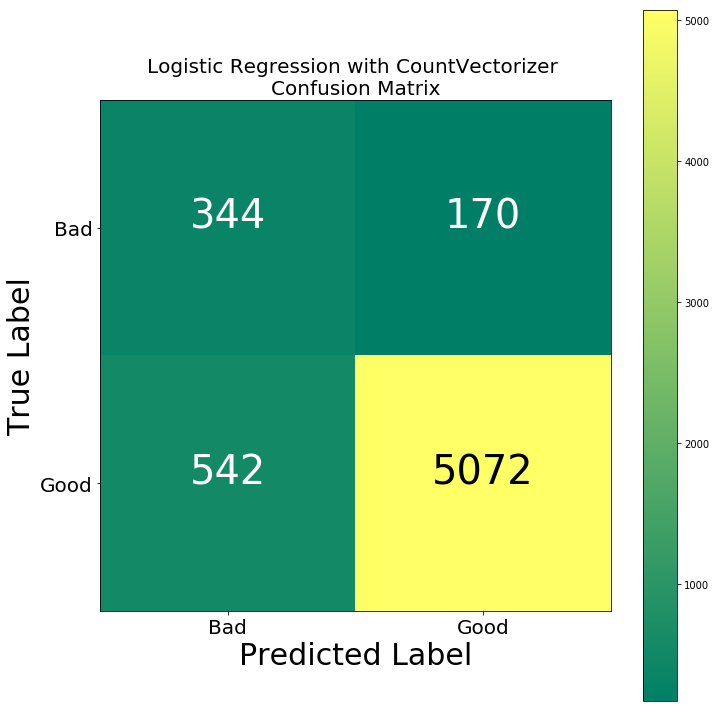

In [45]:
# Print confusion matrix for logistic regression with CountVectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression", "CountVectorizer")

### 1.2 Random Forest with CountVectorizer

In [46]:
# Call the modeling function for random forest classifier with CountVectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8854439771281664


**Classification Report**

In [47]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.73      0.05      0.10       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.82      0.53      0.53      6128
weighted avg       0.90      0.92      0.89      6128



**Confusion Matrix**

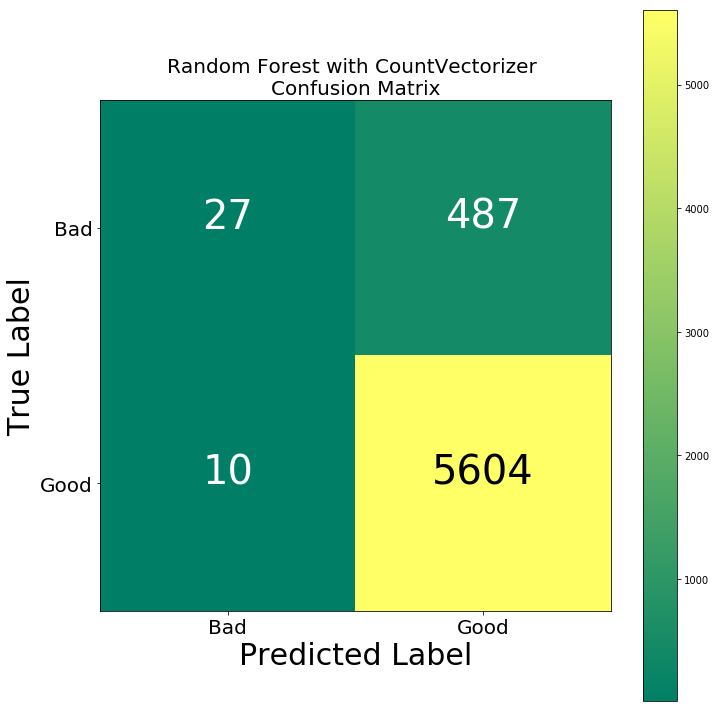

In [49]:
# Print confusion matrix for random forest classifier with CountVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest", "CountVectorizer")

### 1.3 Naive Bayes with CountVectorizer

In [50]:
# Call the modeling function for naive bayes with CountVectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.9125632327667108


**Classification Report**

In [51]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.46      0.61      0.52       514
           1       0.96      0.93      0.95      5614

   micro avg       0.91      0.91      0.91      6128
   macro avg       0.71      0.77      0.74      6128
weighted avg       0.92      0.91      0.91      6128



**Confusion Matrix**

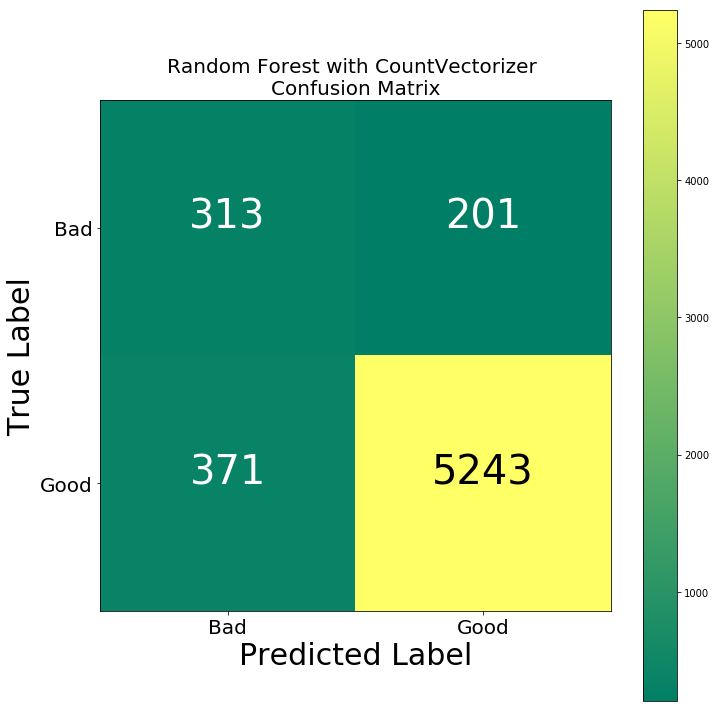

In [52]:
# Print confusion matrix for naive bayes with CountVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Random Forest", "CountVectorizer") 

### 1.4 XGBoost with CountVectorizer

In [53]:
# Call the modeling function for XGBoost with CountVectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.8885706504312775


**Classification Report**

In [54]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.89      0.07      0.12       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.91      0.53      0.54      6128
weighted avg       0.92      0.92      0.89      6128



**Confusion Matrix**

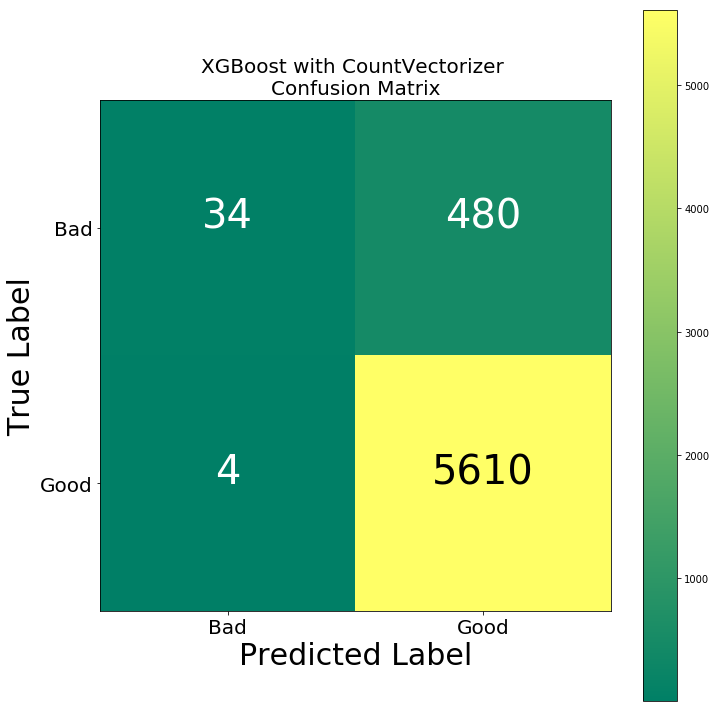

In [55]:
# Print confusion matrix for XGBoost with CountVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost", "CountVectorizer")

### 1.5 Catboosting with CountVectorizer

In [56]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.3017802	total: 102ms	remaining: 2m 33s
1:	learn: 0.2808091	total: 149ms	remaining: 1m 51s
2:	learn: 0.2744844	total: 195ms	remaining: 1m 37s
3:	learn: 0.2711522	total: 240ms	remaining: 1m 29s
4:	learn: 0.2656585	total: 288ms	remaining: 1m 26s
5:	learn: 0.2623887	total: 352ms	remaining: 1m 27s
6:	learn: 0.2594247	total: 400ms	remaining: 1m 25s
7:	learn: 0.2577027	total: 448ms	remaining: 1m 23s
8:	learn: 0.2539087	total: 495ms	remaining: 1m 21s
9:	learn: 0.2512930	total: 544ms	remaining: 1m 20s
10:	learn: 0.2497575	total: 598ms	remaining: 1m 20s
11:	learn: 0.2489807	total: 646ms	remaining: 1m 20s
12:	learn: 0.2473160	total: 694ms	remaining: 1m 19s
13:	learn: 0.2447028	total: 741ms	remaining: 1m 18s
14:	learn: 0.2417820	total: 787ms	remaining: 1m 17s
15:	learn: 0.2403215	total: 842ms	remaining: 1m 18s
16:	learn: 0.2387664	total: 887ms	remaining: 1m 17s
17:	learn: 0.2378341	total: 934ms	remaining: 1m 16s
18:	learn: 0.2369686	total: 979ms	remaining: 1m 16s
19:	learn: 0.2354893	t

161:	learn: 0.1777379	total: 8.18s	remaining: 1m 7s
162:	learn: 0.1776426	total: 8.23s	remaining: 1m 7s
163:	learn: 0.1776106	total: 8.27s	remaining: 1m 7s
164:	learn: 0.1770707	total: 8.31s	remaining: 1m 7s
165:	learn: 0.1770404	total: 8.37s	remaining: 1m 7s
166:	learn: 0.1762254	total: 8.44s	remaining: 1m 7s
167:	learn: 0.1759985	total: 8.49s	remaining: 1m 7s
168:	learn: 0.1756740	total: 8.55s	remaining: 1m 7s
169:	learn: 0.1756610	total: 8.59s	remaining: 1m 7s
170:	learn: 0.1756098	total: 8.64s	remaining: 1m 7s
171:	learn: 0.1755705	total: 8.68s	remaining: 1m 7s
172:	learn: 0.1752438	total: 8.73s	remaining: 1m 6s
173:	learn: 0.1751950	total: 8.77s	remaining: 1m 6s
174:	learn: 0.1748708	total: 8.82s	remaining: 1m 6s
175:	learn: 0.1747784	total: 8.86s	remaining: 1m 6s
176:	learn: 0.1744338	total: 8.91s	remaining: 1m 6s
177:	learn: 0.1744017	total: 8.95s	remaining: 1m 6s
178:	learn: 0.1743109	total: 8.99s	remaining: 1m 6s
179:	learn: 0.1741973	total: 9.03s	remaining: 1m 6s
180:	learn: 

322:	learn: 0.1605434	total: 15.9s	remaining: 57.9s
323:	learn: 0.1605193	total: 16s	remaining: 57.9s
324:	learn: 0.1605011	total: 16.1s	remaining: 58s
325:	learn: 0.1604865	total: 16.1s	remaining: 58.1s
326:	learn: 0.1603887	total: 16.2s	remaining: 58.2s
327:	learn: 0.1602414	total: 16.3s	remaining: 58.2s
328:	learn: 0.1595864	total: 16.4s	remaining: 58.5s
329:	learn: 0.1595499	total: 16.5s	remaining: 58.5s
330:	learn: 0.1595083	total: 16.6s	remaining: 58.5s
331:	learn: 0.1593844	total: 16.6s	remaining: 58.5s
332:	learn: 0.1593654	total: 16.7s	remaining: 58.4s
333:	learn: 0.1593215	total: 16.7s	remaining: 58.4s
334:	learn: 0.1591117	total: 16.8s	remaining: 58.3s
335:	learn: 0.1587782	total: 16.8s	remaining: 58.2s
336:	learn: 0.1586467	total: 16.9s	remaining: 58.2s
337:	learn: 0.1586464	total: 16.9s	remaining: 58.2s
338:	learn: 0.1582511	total: 17s	remaining: 58.3s
339:	learn: 0.1582333	total: 17.1s	remaining: 58.3s
340:	learn: 0.1581385	total: 17.2s	remaining: 58.3s
341:	learn: 0.1581

485:	learn: 0.1497403	total: 23.8s	remaining: 49.7s
486:	learn: 0.1497006	total: 23.8s	remaining: 49.6s
487:	learn: 0.1496781	total: 23.9s	remaining: 49.5s
488:	learn: 0.1496315	total: 23.9s	remaining: 49.5s
489:	learn: 0.1496300	total: 24s	remaining: 49.4s
490:	learn: 0.1495599	total: 24s	remaining: 49.3s
491:	learn: 0.1495591	total: 24s	remaining: 49.3s
492:	learn: 0.1495146	total: 24.1s	remaining: 49.2s
493:	learn: 0.1495023	total: 24.1s	remaining: 49.1s
494:	learn: 0.1494109	total: 24.2s	remaining: 49.1s
495:	learn: 0.1493306	total: 24.2s	remaining: 49s
496:	learn: 0.1493217	total: 24.3s	remaining: 48.9s
497:	learn: 0.1492985	total: 24.3s	remaining: 48.9s
498:	learn: 0.1492934	total: 24.3s	remaining: 48.8s
499:	learn: 0.1492802	total: 24.4s	remaining: 48.7s
500:	learn: 0.1492675	total: 24.4s	remaining: 48.7s
501:	learn: 0.1491833	total: 24.5s	remaining: 48.7s
502:	learn: 0.1491694	total: 24.5s	remaining: 48.6s
503:	learn: 0.1491559	total: 24.6s	remaining: 48.5s
504:	learn: 0.149145

647:	learn: 0.1418930	total: 31.5s	remaining: 41.4s
648:	learn: 0.1418901	total: 31.5s	remaining: 41.4s
649:	learn: 0.1417025	total: 31.6s	remaining: 41.3s
650:	learn: 0.1417022	total: 31.6s	remaining: 41.3s
651:	learn: 0.1415570	total: 31.7s	remaining: 41.2s
652:	learn: 0.1414250	total: 31.7s	remaining: 41.2s
653:	learn: 0.1414249	total: 31.8s	remaining: 41.1s
654:	learn: 0.1414234	total: 31.8s	remaining: 41.1s
655:	learn: 0.1413664	total: 31.9s	remaining: 41s
656:	learn: 0.1413663	total: 31.9s	remaining: 40.9s
657:	learn: 0.1413576	total: 31.9s	remaining: 40.9s
658:	learn: 0.1413575	total: 32s	remaining: 40.8s
659:	learn: 0.1413350	total: 32s	remaining: 40.8s
660:	learn: 0.1412928	total: 32.1s	remaining: 40.7s
661:	learn: 0.1412909	total: 32.1s	remaining: 40.6s
662:	learn: 0.1412880	total: 32.1s	remaining: 40.6s
663:	learn: 0.1412727	total: 32.2s	remaining: 40.5s
664:	learn: 0.1412713	total: 32.2s	remaining: 40.5s
665:	learn: 0.1412422	total: 32.3s	remaining: 40.4s
666:	learn: 0.1412

809:	learn: 0.1365094	total: 39.1s	remaining: 33.3s
810:	learn: 0.1364350	total: 39.1s	remaining: 33.2s
811:	learn: 0.1364350	total: 39.1s	remaining: 33.2s
812:	learn: 0.1364199	total: 39.2s	remaining: 33.1s
813:	learn: 0.1364194	total: 39.2s	remaining: 33s
814:	learn: 0.1364131	total: 39.2s	remaining: 33s
815:	learn: 0.1364127	total: 39.3s	remaining: 32.9s
816:	learn: 0.1364122	total: 39.3s	remaining: 32.9s
817:	learn: 0.1363773	total: 39.4s	remaining: 32.8s
818:	learn: 0.1363746	total: 39.4s	remaining: 32.8s
819:	learn: 0.1363550	total: 39.5s	remaining: 32.7s
820:	learn: 0.1363300	total: 39.5s	remaining: 32.7s
821:	learn: 0.1363293	total: 39.6s	remaining: 32.6s
822:	learn: 0.1362699	total: 39.6s	remaining: 32.6s
823:	learn: 0.1362698	total: 39.6s	remaining: 32.5s
824:	learn: 0.1362672	total: 39.7s	remaining: 32.5s
825:	learn: 0.1362608	total: 39.7s	remaining: 32.4s
826:	learn: 0.1361906	total: 39.8s	remaining: 32.4s
827:	learn: 0.1361887	total: 39.8s	remaining: 32.3s
828:	learn: 0.13

970:	learn: 0.1309347	total: 46.1s	remaining: 25.1s
971:	learn: 0.1309337	total: 46.2s	remaining: 25.1s
972:	learn: 0.1309335	total: 46.2s	remaining: 25s
973:	learn: 0.1309335	total: 46.3s	remaining: 25s
974:	learn: 0.1309333	total: 46.3s	remaining: 24.9s
975:	learn: 0.1309324	total: 46.3s	remaining: 24.9s
976:	learn: 0.1309303	total: 46.4s	remaining: 24.8s
977:	learn: 0.1309109	total: 46.4s	remaining: 24.8s
978:	learn: 0.1309109	total: 46.5s	remaining: 24.7s
979:	learn: 0.1309105	total: 46.5s	remaining: 24.7s
980:	learn: 0.1309105	total: 46.6s	remaining: 24.6s
981:	learn: 0.1309105	total: 46.6s	remaining: 24.6s
982:	learn: 0.1309104	total: 46.6s	remaining: 24.5s
983:	learn: 0.1309104	total: 46.7s	remaining: 24.5s
984:	learn: 0.1309104	total: 46.7s	remaining: 24.4s
985:	learn: 0.1308571	total: 46.8s	remaining: 24.4s
986:	learn: 0.1308561	total: 46.8s	remaining: 24.3s
987:	learn: 0.1308555	total: 46.8s	remaining: 24.3s
988:	learn: 0.1308529	total: 46.9s	remaining: 24.2s
989:	learn: 0.13

1127:	learn: 0.1284615	total: 52.7s	remaining: 17.4s
1128:	learn: 0.1284592	total: 52.8s	remaining: 17.3s
1129:	learn: 0.1284590	total: 52.8s	remaining: 17.3s
1130:	learn: 0.1284590	total: 52.8s	remaining: 17.2s
1131:	learn: 0.1284581	total: 52.9s	remaining: 17.2s
1132:	learn: 0.1284579	total: 52.9s	remaining: 17.1s
1133:	learn: 0.1283615	total: 53s	remaining: 17.1s
1134:	learn: 0.1283321	total: 53s	remaining: 17s
1135:	learn: 0.1283301	total: 53.1s	remaining: 17s
1136:	learn: 0.1283298	total: 53.1s	remaining: 16.9s
1137:	learn: 0.1283283	total: 53.1s	remaining: 16.9s
1138:	learn: 0.1283209	total: 53.2s	remaining: 16.9s
1139:	learn: 0.1282159	total: 53.2s	remaining: 16.8s
1140:	learn: 0.1282159	total: 53.3s	remaining: 16.8s
1141:	learn: 0.1282154	total: 53.3s	remaining: 16.7s
1142:	learn: 0.1282030	total: 53.3s	remaining: 16.7s
1143:	learn: 0.1281980	total: 53.4s	remaining: 16.6s
1144:	learn: 0.1281975	total: 53.4s	remaining: 16.6s
1145:	learn: 0.1281958	total: 53.5s	remaining: 16.5s
1

1287:	learn: 0.1254842	total: 59.1s	remaining: 9.72s
1288:	learn: 0.1254826	total: 59.1s	remaining: 9.68s
1289:	learn: 0.1254722	total: 59.2s	remaining: 9.63s
1290:	learn: 0.1253521	total: 59.2s	remaining: 9.58s
1291:	learn: 0.1253115	total: 59.2s	remaining: 9.54s
1292:	learn: 0.1253112	total: 59.3s	remaining: 9.49s
1293:	learn: 0.1252998	total: 59.3s	remaining: 9.45s
1294:	learn: 0.1252984	total: 59.4s	remaining: 9.4s
1295:	learn: 0.1251912	total: 59.4s	remaining: 9.35s
1296:	learn: 0.1250779	total: 59.5s	remaining: 9.31s
1297:	learn: 0.1250495	total: 59.5s	remaining: 9.26s
1298:	learn: 0.1250492	total: 59.6s	remaining: 9.22s
1299:	learn: 0.1250282	total: 59.6s	remaining: 9.17s
1300:	learn: 0.1248879	total: 59.6s	remaining: 9.12s
1301:	learn: 0.1248790	total: 59.7s	remaining: 9.08s
1302:	learn: 0.1248532	total: 59.7s	remaining: 9.03s
1303:	learn: 0.1248525	total: 59.8s	remaining: 8.98s
1304:	learn: 0.1248523	total: 59.8s	remaining: 8.94s
1305:	learn: 0.1248456	total: 59.8s	remaining: 

1444:	learn: 0.1211074	total: 1m 6s	remaining: 2.52s
1445:	learn: 0.1211066	total: 1m 6s	remaining: 2.48s
1446:	learn: 0.1210871	total: 1m 6s	remaining: 2.43s
1447:	learn: 0.1208620	total: 1m 6s	remaining: 2.39s
1448:	learn: 0.1208616	total: 1m 6s	remaining: 2.34s
1449:	learn: 0.1208590	total: 1m 6s	remaining: 2.3s
1450:	learn: 0.1208589	total: 1m 6s	remaining: 2.25s
1451:	learn: 0.1208545	total: 1m 6s	remaining: 2.21s
1452:	learn: 0.1208544	total: 1m 6s	remaining: 2.16s
1453:	learn: 0.1208304	total: 1m 6s	remaining: 2.11s
1454:	learn: 0.1208260	total: 1m 6s	remaining: 2.07s
1455:	learn: 0.1208248	total: 1m 6s	remaining: 2.02s
1456:	learn: 0.1206147	total: 1m 6s	remaining: 1.98s
1457:	learn: 0.1206114	total: 1m 7s	remaining: 1.93s
1458:	learn: 0.1206050	total: 1m 7s	remaining: 1.88s
1459:	learn: 0.1206043	total: 1m 7s	remaining: 1.84s
1460:	learn: 0.1206043	total: 1m 7s	remaining: 1.79s
1461:	learn: 0.1205952	total: 1m 7s	remaining: 1.75s
1462:	learn: 0.1205948	total: 1m 7s	remaining: 

**Classification Report**

In [57]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43       514
           1       0.94      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.78      0.66      0.69      6128
weighted avg       0.91      0.93      0.92      6128



**Confusion Matrix**

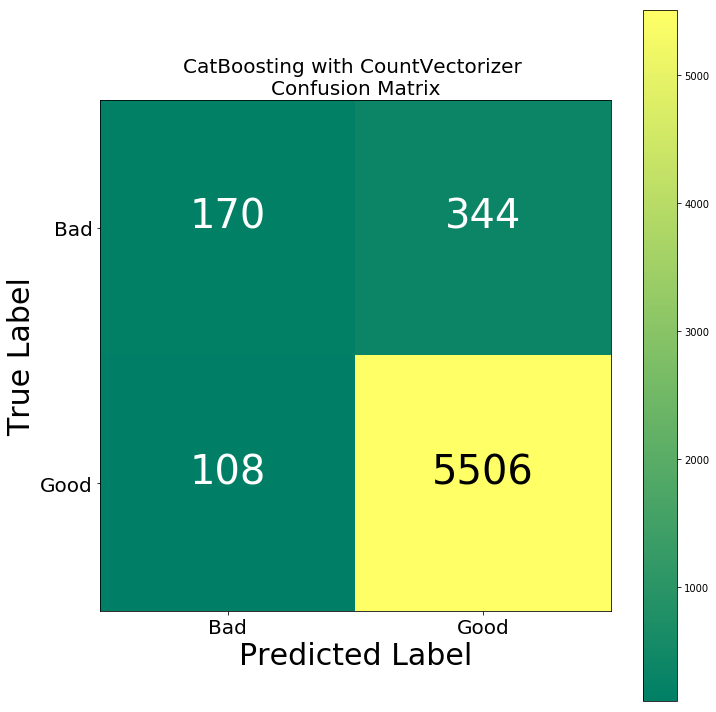

In [58]:
# Print confusion matrix for CatBoost with CountVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting", "CountVectorizer")

### 1.6 Comparision of Models 

**Functions for Algorithms Comparison**

In [59]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
global comparison_matrix
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [60]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Function for f1 score plotting**

In [61]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Model Comparison Table**

In [62]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [63]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with Expanded Stopword List\n')
df_tv2


Comparision Matrix of Modeling with Expanded Stopword List



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.883812 bad       0.388262  0.669261  0.491429   
                                  good      0.967570  0.903456  0.934414   
                                  average   0.918979  0.883812  0.897258   
           Random Forest 0.918897 bad       0.729730  0.052529  0.098004   
                                  good      0.920046  0.998219  0.957540   
                                  average   0.904083  0.918897  0.885444   
           Naive Bayes   0.906658 bad       0.457602  0.608949  0.522538   
                                  good      0.963079  0.933915  0.948273   
                                  average   0.920681  0.906658  0.912563   
           XGBoost       0.921018 bad       0.894737  0.066148  0.123188   
                                  good      0.921182  0.999287  0.958647   
                                  average   0.918964  0.921018  0.888571   
           CatBoost      0.926240 bad       0.611511  0.330739  0.429293   
                                  good      0.941197  0.980762  0.960572   
                                  average   0.913543  0.926240  0.916010   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.883812 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.918897 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.906658 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.921018 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.926240 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 scores**

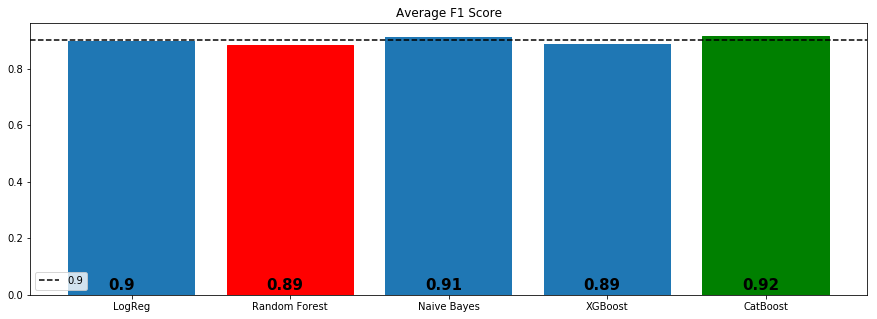

In [64]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

# 2. Synthetic Minority Oversampling Technique (SMOTE)

In [65]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
df_text, df_target = sm.fit_sample(count_vect_train, y_train)
print (df_text.shape)
print (df_target.shape)

(33622, 3270)
(33622,)


In [66]:
from collections import Counter
Counter(df_target)

Counter({1: 16811, 0: 16811})

### 2.1 Logistic Regression

In [67]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_logreg = y_pred

f1 score: 0.8774536456248323


**Classification Report**

In [68]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_logreg))

              precision    recall  f1-score   support

           0       0.31      0.53      0.39       514
           1       0.95      0.89      0.92      5614

   micro avg       0.86      0.86      0.86      6128
   macro avg       0.63      0.71      0.66      6128
weighted avg       0.90      0.86      0.88      6128



**Confusion Matrix**

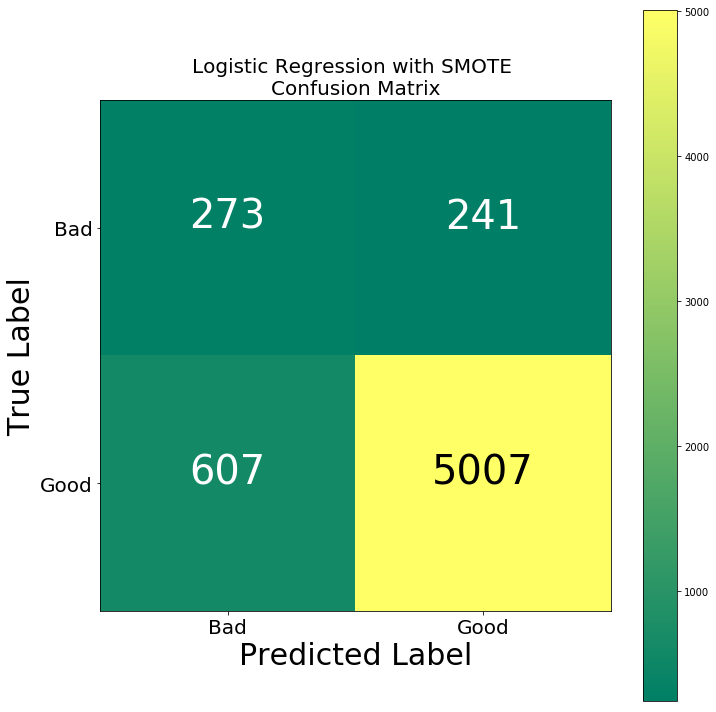

In [69]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_sm_logreg, "Logistic Regression", "SMOTE")

### 2.2 Random Forest

In [70]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_rf = y_pred

f1 score: 0.871084089152953


**Classification Report**

In [71]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_rf))

              precision    recall  f1-score   support

           0       0.20      0.14      0.16       514
           1       0.92      0.95      0.94      5614

   micro avg       0.88      0.88      0.88      6128
   macro avg       0.56      0.54      0.55      6128
weighted avg       0.86      0.88      0.87      6128



**Confusion Matrix**

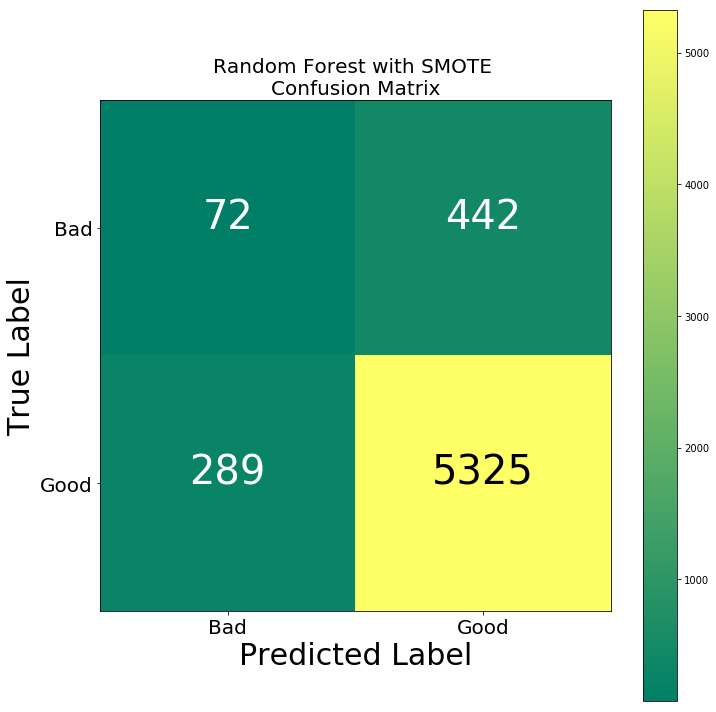

In [72]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_sm_rf, "Random Forest", "SMOTE")

### 2.3 Naive Bayes

In [73]:
# Call the modeling function for naive bayes and print f1 score
modeling(MultinomialNB(), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_nb = y_pred

f1 score: 0.893567326133402


**Classification Report**

In [74]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_nb))

              precision    recall  f1-score   support

           0       0.37      0.56      0.44       514
           1       0.96      0.91      0.93      5614

   micro avg       0.88      0.88      0.88      6128
   macro avg       0.66      0.73      0.69      6128
weighted avg       0.91      0.88      0.89      6128



**Confusion Matrix**

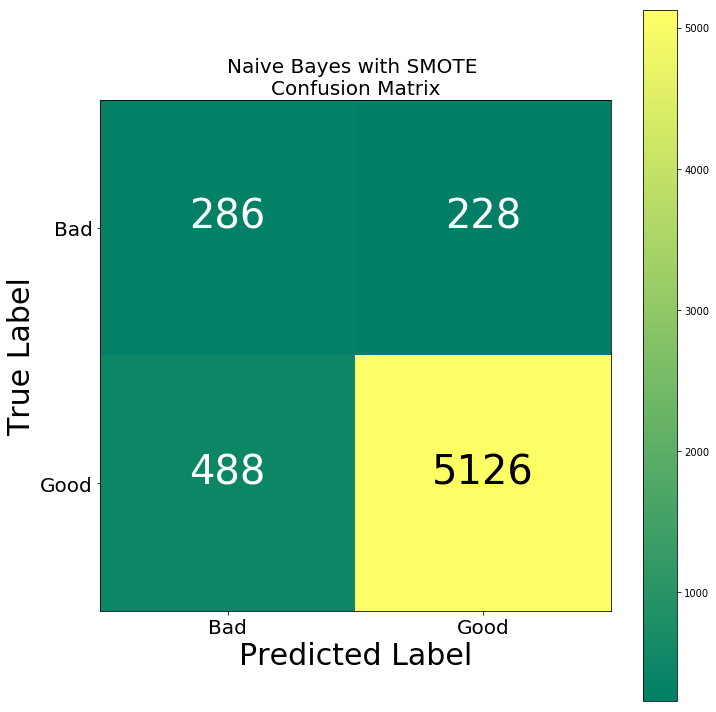

In [75]:
# Print confusion matrix for naive bayes
disp_confusion_matrix(y_pred_sm_nb, "Naive Bayes", "SMOTE")

### 2.4 XGBoost 

In [76]:
# Call the modeling function for XGBoost and print f1 score
modeling(XGBClassifier(), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_xgb = y_pred

f1 score: 0.793170112136524


**Classification Report**

In [77]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_xgb))

              precision    recall  f1-score   support

           0       0.15      0.43      0.22       514
           1       0.94      0.77      0.85      5614

   micro avg       0.74      0.74      0.74      6128
   macro avg       0.54      0.60      0.53      6128
weighted avg       0.87      0.74      0.79      6128



**Confusion Matrix**

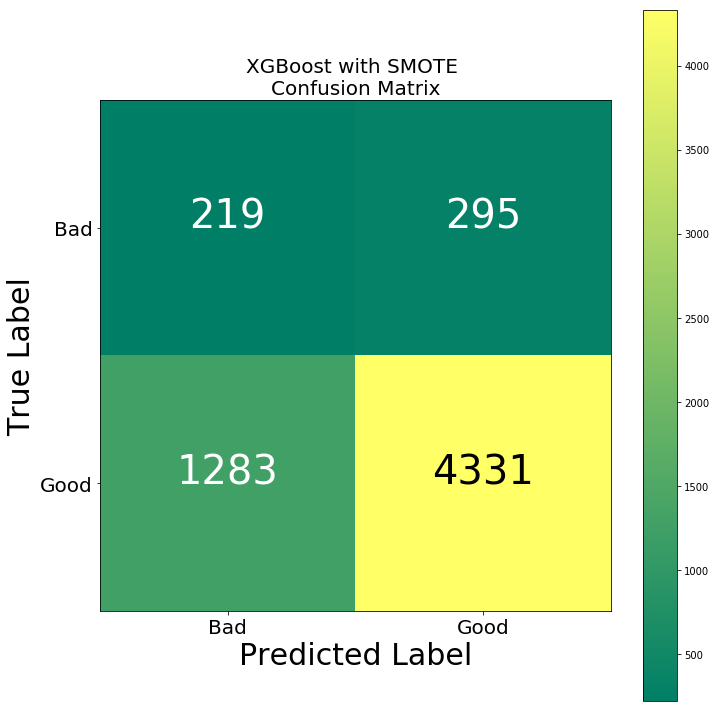

In [78]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_sm_xgb, "XGBoost", "SMOTE")

### 2.5 CatBoost 

In [79]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_catboost = y_pred

0:	learn: 0.6438514	total: 84.3ms	remaining: 2m 6s
1:	learn: 0.6064250	total: 173ms	remaining: 2m 9s
2:	learn: 0.5718804	total: 257ms	remaining: 2m 8s
3:	learn: 0.5457218	total: 344ms	remaining: 2m 8s
4:	learn: 0.5235733	total: 419ms	remaining: 2m 5s
5:	learn: 0.5058329	total: 494ms	remaining: 2m 2s
6:	learn: 0.4888990	total: 576ms	remaining: 2m 2s
7:	learn: 0.4752015	total: 647ms	remaining: 2m
8:	learn: 0.4606340	total: 717ms	remaining: 1m 58s
9:	learn: 0.4498637	total: 790ms	remaining: 1m 57s
10:	learn: 0.4403223	total: 855ms	remaining: 1m 55s
11:	learn: 0.4326511	total: 965ms	remaining: 1m 59s
12:	learn: 0.4269001	total: 1.04s	remaining: 1m 59s
13:	learn: 0.4207645	total: 1.11s	remaining: 1m 58s
14:	learn: 0.4135619	total: 1.19s	remaining: 1m 57s
15:	learn: 0.4069524	total: 1.27s	remaining: 1m 57s
16:	learn: 0.4016292	total: 1.35s	remaining: 1m 58s
17:	learn: 0.3963802	total: 1.43s	remaining: 1m 57s
18:	learn: 0.3917606	total: 1.5s	remaining: 1m 57s
19:	learn: 0.3866672	total: 1.57s

159:	learn: 0.2428702	total: 12.6s	remaining: 1m 45s
160:	learn: 0.2426829	total: 12.7s	remaining: 1m 45s
161:	learn: 0.2416894	total: 12.7s	remaining: 1m 45s
162:	learn: 0.2413792	total: 12.8s	remaining: 1m 44s
163:	learn: 0.2406001	total: 12.9s	remaining: 1m 44s
164:	learn: 0.2395764	total: 12.9s	remaining: 1m 44s
165:	learn: 0.2389876	total: 13.1s	remaining: 1m 44s
166:	learn: 0.2383971	total: 13.1s	remaining: 1m 44s
167:	learn: 0.2379627	total: 13.2s	remaining: 1m 44s
168:	learn: 0.2372709	total: 13.3s	remaining: 1m 44s
169:	learn: 0.2369982	total: 13.4s	remaining: 1m 44s
170:	learn: 0.2367192	total: 13.5s	remaining: 1m 44s
171:	learn: 0.2365327	total: 13.5s	remaining: 1m 44s
172:	learn: 0.2362980	total: 13.6s	remaining: 1m 44s
173:	learn: 0.2357267	total: 13.7s	remaining: 1m 44s
174:	learn: 0.2356268	total: 13.7s	remaining: 1m 44s
175:	learn: 0.2355063	total: 13.8s	remaining: 1m 43s
176:	learn: 0.2354000	total: 13.9s	remaining: 1m 43s
177:	learn: 0.2351866	total: 14s	remaining: 1m

318:	learn: 0.2108724	total: 24s	remaining: 1m 28s
319:	learn: 0.2108522	total: 24.1s	remaining: 1m 28s
320:	learn: 0.2108248	total: 24.1s	remaining: 1m 28s
321:	learn: 0.2108225	total: 24.2s	remaining: 1m 28s
322:	learn: 0.2107635	total: 24.3s	remaining: 1m 28s
323:	learn: 0.2106390	total: 24.3s	remaining: 1m 28s
324:	learn: 0.2106376	total: 24.4s	remaining: 1m 28s
325:	learn: 0.2105851	total: 24.5s	remaining: 1m 28s
326:	learn: 0.2104289	total: 24.5s	remaining: 1m 27s
327:	learn: 0.2100389	total: 24.6s	remaining: 1m 27s
328:	learn: 0.2098999	total: 24.6s	remaining: 1m 27s
329:	learn: 0.2098018	total: 24.7s	remaining: 1m 27s
330:	learn: 0.2091555	total: 24.8s	remaining: 1m 27s
331:	learn: 0.2090213	total: 24.8s	remaining: 1m 27s
332:	learn: 0.2088940	total: 24.9s	remaining: 1m 27s
333:	learn: 0.2088719	total: 25s	remaining: 1m 27s
334:	learn: 0.2088558	total: 25s	remaining: 1m 27s
335:	learn: 0.2088449	total: 25.1s	remaining: 1m 26s
336:	learn: 0.2082879	total: 25.2s	remaining: 1m 26s

475:	learn: 0.1957154	total: 34.3s	remaining: 1m 13s
476:	learn: 0.1956844	total: 34.4s	remaining: 1m 13s
477:	learn: 0.1956310	total: 34.4s	remaining: 1m 13s
478:	learn: 0.1955773	total: 34.5s	remaining: 1m 13s
479:	learn: 0.1955722	total: 34.6s	remaining: 1m 13s
480:	learn: 0.1955698	total: 34.6s	remaining: 1m 13s
481:	learn: 0.1955433	total: 34.7s	remaining: 1m 13s
482:	learn: 0.1950596	total: 34.8s	remaining: 1m 13s
483:	learn: 0.1944636	total: 34.8s	remaining: 1m 13s
484:	learn: 0.1943472	total: 34.9s	remaining: 1m 13s
485:	learn: 0.1943427	total: 35s	remaining: 1m 12s
486:	learn: 0.1943397	total: 35s	remaining: 1m 12s
487:	learn: 0.1940726	total: 35.1s	remaining: 1m 12s
488:	learn: 0.1939589	total: 35.2s	remaining: 1m 12s
489:	learn: 0.1939258	total: 35.2s	remaining: 1m 12s
490:	learn: 0.1939181	total: 35.3s	remaining: 1m 12s
491:	learn: 0.1938554	total: 35.4s	remaining: 1m 12s
492:	learn: 0.1938262	total: 35.4s	remaining: 1m 12s
493:	learn: 0.1937434	total: 35.5s	remaining: 1m 1

633:	learn: 0.1812889	total: 45.3s	remaining: 1m 1s
634:	learn: 0.1812684	total: 45.4s	remaining: 1m 1s
635:	learn: 0.1812684	total: 45.5s	remaining: 1m 1s
636:	learn: 0.1812680	total: 45.5s	remaining: 1m 1s
637:	learn: 0.1810938	total: 45.6s	remaining: 1m 1s
638:	learn: 0.1808932	total: 45.7s	remaining: 1m 1s
639:	learn: 0.1807022	total: 45.7s	remaining: 1m 1s
640:	learn: 0.1806639	total: 45.8s	remaining: 1m 1s
641:	learn: 0.1806619	total: 45.9s	remaining: 1m 1s
642:	learn: 0.1806335	total: 45.9s	remaining: 1m 1s
643:	learn: 0.1805501	total: 46s	remaining: 1m 1s
644:	learn: 0.1805369	total: 46.1s	remaining: 1m 1s
645:	learn: 0.1804408	total: 46.1s	remaining: 1m
646:	learn: 0.1804388	total: 46.2s	remaining: 1m
647:	learn: 0.1803484	total: 46.3s	remaining: 1m
648:	learn: 0.1803473	total: 46.3s	remaining: 1m
649:	learn: 0.1802078	total: 46.4s	remaining: 1m
650:	learn: 0.1801307	total: 46.5s	remaining: 1m
651:	learn: 0.1800069	total: 46.5s	remaining: 1m
652:	learn: 0.1798399	total: 46.6s	

795:	learn: 0.1722862	total: 56.4s	remaining: 49.9s
796:	learn: 0.1722862	total: 56.5s	remaining: 49.8s
797:	learn: 0.1722862	total: 56.5s	remaining: 49.7s
798:	learn: 0.1721807	total: 56.6s	remaining: 49.7s
799:	learn: 0.1719086	total: 56.7s	remaining: 49.6s
800:	learn: 0.1718708	total: 56.7s	remaining: 49.5s
801:	learn: 0.1718517	total: 56.8s	remaining: 49.4s
802:	learn: 0.1718348	total: 56.9s	remaining: 49.4s
803:	learn: 0.1717620	total: 56.9s	remaining: 49.3s
804:	learn: 0.1716445	total: 57s	remaining: 49.2s
805:	learn: 0.1715934	total: 57.1s	remaining: 49.1s
806:	learn: 0.1715934	total: 57.1s	remaining: 49s
807:	learn: 0.1715934	total: 57.2s	remaining: 49s
808:	learn: 0.1715912	total: 57.2s	remaining: 48.9s
809:	learn: 0.1715912	total: 57.3s	remaining: 48.8s
810:	learn: 0.1715713	total: 57.4s	remaining: 48.7s
811:	learn: 0.1714905	total: 57.4s	remaining: 48.7s
812:	learn: 0.1712546	total: 57.5s	remaining: 48.6s
813:	learn: 0.1712544	total: 57.5s	remaining: 48.5s
814:	learn: 0.1712

958:	learn: 0.1647907	total: 1m 6s	remaining: 37.7s
959:	learn: 0.1647884	total: 1m 6s	remaining: 37.6s
960:	learn: 0.1647796	total: 1m 6s	remaining: 37.5s
961:	learn: 0.1645692	total: 1m 6s	remaining: 37.4s
962:	learn: 0.1645691	total: 1m 7s	remaining: 37.4s
963:	learn: 0.1645191	total: 1m 7s	remaining: 37.3s
964:	learn: 0.1645169	total: 1m 7s	remaining: 37.2s
965:	learn: 0.1638546	total: 1m 7s	remaining: 37.1s
966:	learn: 0.1638546	total: 1m 7s	remaining: 37.1s
967:	learn: 0.1638484	total: 1m 7s	remaining: 37s
968:	learn: 0.1638422	total: 1m 7s	remaining: 36.9s
969:	learn: 0.1638406	total: 1m 7s	remaining: 36.9s
970:	learn: 0.1638404	total: 1m 7s	remaining: 36.8s
971:	learn: 0.1638403	total: 1m 7s	remaining: 36.7s
972:	learn: 0.1636870	total: 1m 7s	remaining: 36.6s
973:	learn: 0.1635604	total: 1m 7s	remaining: 36.6s
974:	learn: 0.1635245	total: 1m 7s	remaining: 36.5s
975:	learn: 0.1635173	total: 1m 7s	remaining: 36.4s
976:	learn: 0.1634275	total: 1m 7s	remaining: 36.3s
977:	learn: 0.

1113:	learn: 0.1598038	total: 1m 16s	remaining: 26.5s
1114:	learn: 0.1597237	total: 1m 16s	remaining: 26.4s
1115:	learn: 0.1597231	total: 1m 16s	remaining: 26.4s
1116:	learn: 0.1595753	total: 1m 16s	remaining: 26.3s
1117:	learn: 0.1595752	total: 1m 16s	remaining: 26.2s
1118:	learn: 0.1595747	total: 1m 16s	remaining: 26.1s
1119:	learn: 0.1595689	total: 1m 16s	remaining: 26.1s
1120:	learn: 0.1595636	total: 1m 16s	remaining: 26s
1121:	learn: 0.1595635	total: 1m 16s	remaining: 25.9s
1122:	learn: 0.1595425	total: 1m 17s	remaining: 25.9s
1123:	learn: 0.1595425	total: 1m 17s	remaining: 25.8s
1124:	learn: 0.1595382	total: 1m 17s	remaining: 25.7s
1125:	learn: 0.1594458	total: 1m 17s	remaining: 25.6s
1126:	learn: 0.1594414	total: 1m 17s	remaining: 25.6s
1127:	learn: 0.1594413	total: 1m 17s	remaining: 25.5s
1128:	learn: 0.1594368	total: 1m 17s	remaining: 25.4s
1129:	learn: 0.1594293	total: 1m 17s	remaining: 25.4s
1130:	learn: 0.1594291	total: 1m 17s	remaining: 25.3s
1131:	learn: 0.1594199	total: 

1269:	learn: 0.1557667	total: 1m 26s	remaining: 15.6s
1270:	learn: 0.1557654	total: 1m 26s	remaining: 15.5s
1271:	learn: 0.1557525	total: 1m 26s	remaining: 15.5s
1272:	learn: 0.1557021	total: 1m 26s	remaining: 15.4s
1273:	learn: 0.1556356	total: 1m 26s	remaining: 15.3s
1274:	learn: 0.1556192	total: 1m 26s	remaining: 15.3s
1275:	learn: 0.1556108	total: 1m 26s	remaining: 15.2s
1276:	learn: 0.1555146	total: 1m 26s	remaining: 15.1s
1277:	learn: 0.1555146	total: 1m 26s	remaining: 15.1s
1278:	learn: 0.1554618	total: 1m 26s	remaining: 15s
1279:	learn: 0.1554391	total: 1m 26s	remaining: 14.9s
1280:	learn: 0.1553957	total: 1m 26s	remaining: 14.8s
1281:	learn: 0.1553777	total: 1m 26s	remaining: 14.8s
1282:	learn: 0.1553243	total: 1m 26s	remaining: 14.7s
1283:	learn: 0.1553111	total: 1m 27s	remaining: 14.6s
1284:	learn: 0.1552209	total: 1m 27s	remaining: 14.6s
1285:	learn: 0.1552204	total: 1m 27s	remaining: 14.5s
1286:	learn: 0.1552203	total: 1m 27s	remaining: 14.4s
1287:	learn: 0.1552203	total: 

1425:	learn: 0.1526547	total: 1m 35s	remaining: 4.97s
1426:	learn: 0.1526099	total: 1m 35s	remaining: 4.9s
1427:	learn: 0.1526049	total: 1m 35s	remaining: 4.83s
1428:	learn: 0.1523791	total: 1m 35s	remaining: 4.77s
1429:	learn: 0.1523713	total: 1m 35s	remaining: 4.7s
1430:	learn: 0.1523532	total: 1m 36s	remaining: 4.63s
1431:	learn: 0.1523519	total: 1m 36s	remaining: 4.56s
1432:	learn: 0.1520474	total: 1m 36s	remaining: 4.5s
1433:	learn: 0.1520474	total: 1m 36s	remaining: 4.43s
1434:	learn: 0.1520425	total: 1m 36s	remaining: 4.36s
1435:	learn: 0.1520424	total: 1m 36s	remaining: 4.29s
1436:	learn: 0.1520397	total: 1m 36s	remaining: 4.23s
1437:	learn: 0.1520397	total: 1m 36s	remaining: 4.16s
1438:	learn: 0.1520364	total: 1m 36s	remaining: 4.09s
1439:	learn: 0.1520337	total: 1m 36s	remaining: 4.03s
1440:	learn: 0.1519914	total: 1m 36s	remaining: 3.96s
1441:	learn: 0.1517410	total: 1m 36s	remaining: 3.89s
1442:	learn: 0.1517304	total: 1m 36s	remaining: 3.82s
1443:	learn: 0.1517302	total: 1

**Classification Report**

In [80]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_catboost))

              precision    recall  f1-score   support

           0       0.28      0.50      0.36       514
           1       0.95      0.88      0.92      5614

   micro avg       0.85      0.85      0.85      6128
   macro avg       0.62      0.69      0.64      6128
weighted avg       0.89      0.85      0.87      6128



**Confusion Matrix**

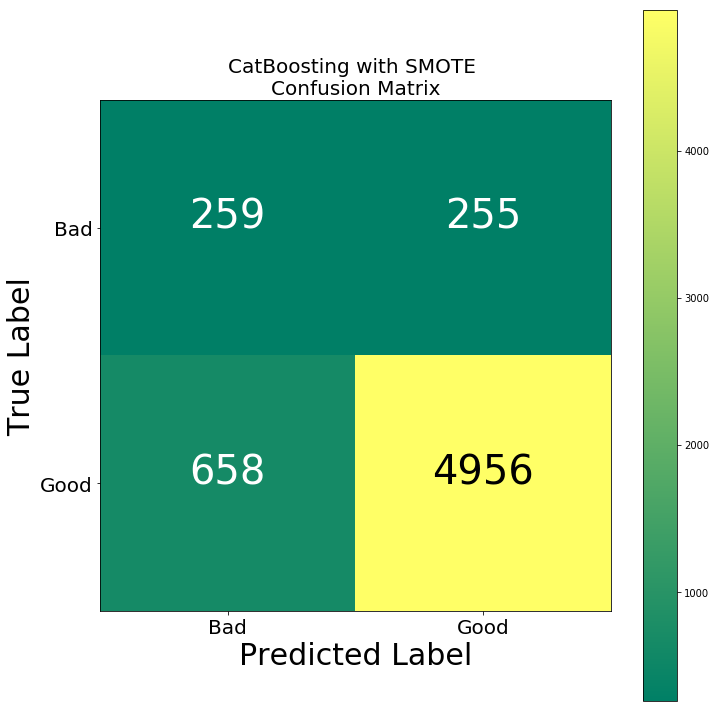

In [81]:
# Print confusion matrix for CatBoost
disp_confusion_matrix(y_pred_sm_catboost, "CatBoosting", "SMOTE")

### 2.6 Comparison of SMOTE Models

In [85]:
comparison_table(y_preds = [y_pred_sm_logreg, y_pred_sm_rf, y_pred_sm_nb, y_pred_sm_xgb, y_pred_sm_catboost], 
                 labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'] )

In [86]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with SMOTE\n')
df_tv2


Comparision Matrix of Modeling with SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.861619 bad       0.310227  0.531128  0.391679   
                                  good      0.954078  0.891877  0.921930   
                                  average   0.900073  0.861619  0.877454   
           Random Forest 0.880711 bad       0.199446  0.140078  0.164571   
                                  good      0.923357  0.948522  0.935770   
                                  average   0.862637  0.880711  0.871084   
           Naive Bayes   0.883159 bad       0.369509  0.556420  0.444099   
                                  good      0.957415  0.913074  0.934719   
                                  average   0.908103  0.883159  0.893567   
           XGBoost       0.742493 bad       0.145806  0.426070  0.217262   
                                  good      0.936230  0.771464  0.845898   
                                  average   0.869931  0.742493  0.793170   
           CatBoost      0.851012 bad       0.282443  0.503891  0.361985   
                                  good      0.951065  0.882793  0.915658   
                                  average   0.894983  0.851012  0.869218   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.861619 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.880711 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.883159 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.742493 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.851012 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

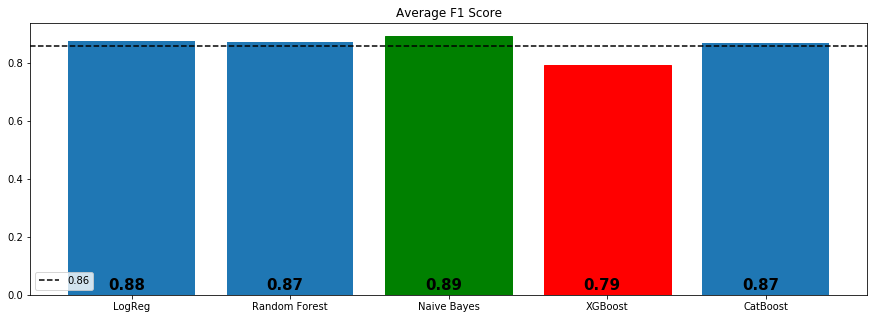

In [87]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 3. Applying PCA to Decrease the Linear Dimensionality + SMOTE

In [88]:
from sklearn.decomposition import PCA
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.975)
pca = PCA(random_state=42)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
pca_X_train = pca.fit_transform(count_vect_train)

count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()
pca_X_test = pca.transform(count_vect_test)

In [89]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
pca_text, pca_target = sm.fit_sample(pca_X_train, y_train)
print (pca_text.shape)
print (pca_target.shape)

(33622, 3270)
(33622,)


In [90]:
Counter(pca_target)

Counter({1: 16811, 0: 16811})

### 3.1 Logistic Regression

In [91]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_logreg = y_pred

f1 score: 0.9029462787927295


**Classification Report**

In [92]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_logreg))

              precision    recall  f1-score   support

           0       0.41      0.64      0.50       514
           1       0.97      0.92      0.94      5614

   micro avg       0.89      0.89      0.89      6128
   macro avg       0.69      0.78      0.72      6128
weighted avg       0.92      0.89      0.90      6128



**Confusion Matrix**

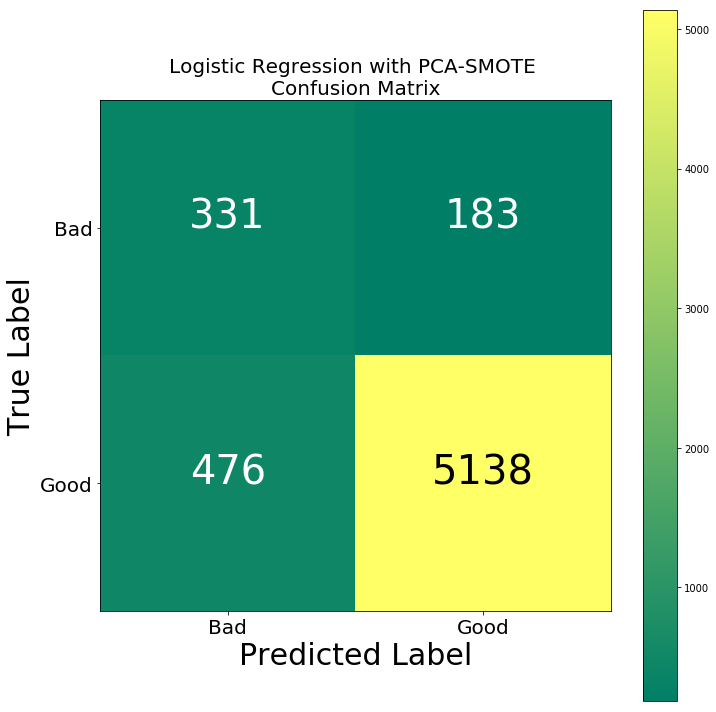

In [93]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_pcasm_logreg, "Logistic Regression", "PCA-SMOTE")

### 3.2 Random Forest

In [94]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_rf = y_pred

f1 score: 0.8751686781657763


**Classification Report**

In [95]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_rf))

              precision    recall  f1-score   support

           0       0.16      0.03      0.05       514
           1       0.92      0.99      0.95      5614

   micro avg       0.91      0.91      0.91      6128
   macro avg       0.54      0.51      0.50      6128
weighted avg       0.85      0.91      0.88      6128



**Confusion Matrix**

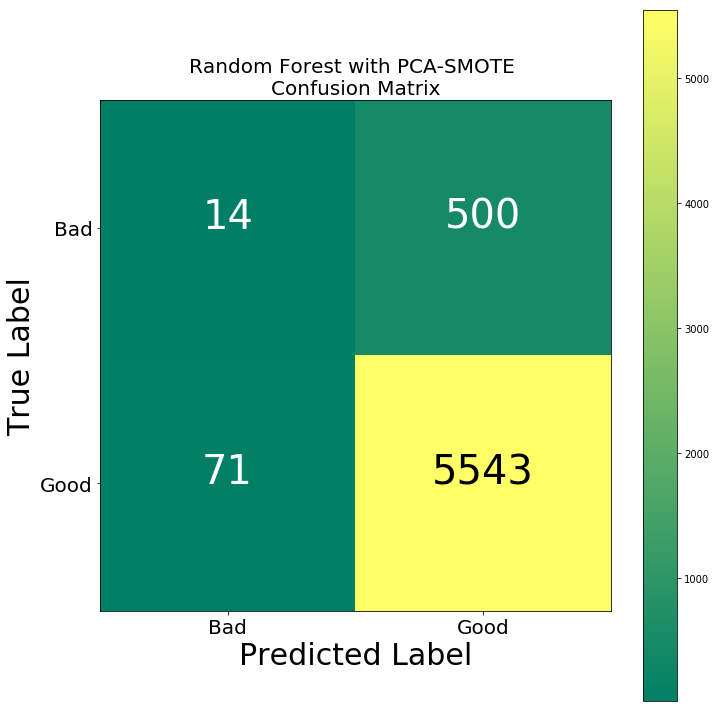

In [96]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_pcasm_rf, "Random Forest", "PCA-SMOTE")

### 3.3 XGBoost

In [98]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_xgb = y_pred

f1 score: 0.8429952077767622


**Classification Report**

In [99]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_xgb))

              precision    recall  f1-score   support

           0       0.20      0.39      0.26       514
           1       0.94      0.86      0.90      5614

   micro avg       0.82      0.82      0.82      6128
   macro avg       0.57      0.62      0.58      6128
weighted avg       0.88      0.82      0.84      6128



**Confusion Matrix**

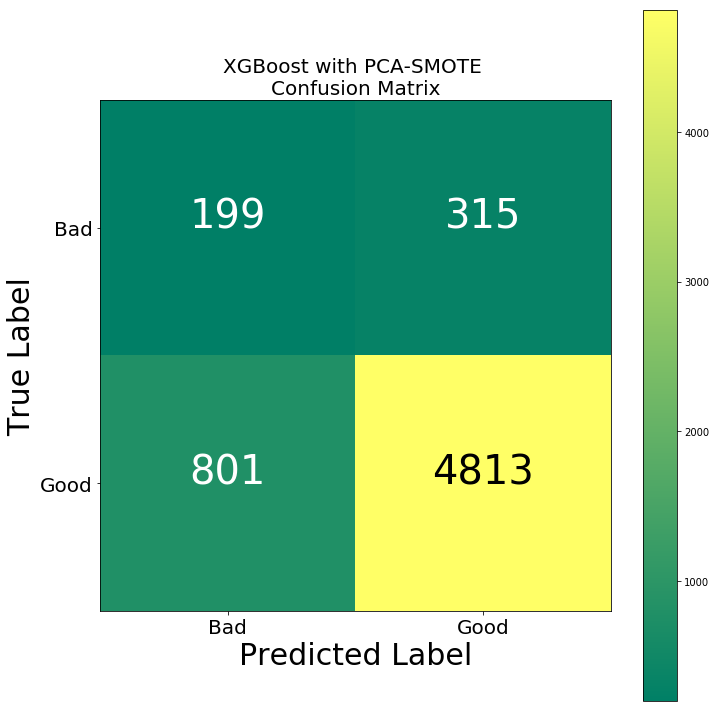

In [100]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_pcasm_xgb, "XGBoost", "PCA-SMOTE")

### 3.4 CatBoost

In [101]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_catboost = y_pred

0:	learn: 0.6488209	total: 301ms	remaining: 7m 31s
1:	learn: 0.6230694	total: 491ms	remaining: 6m 7s
2:	learn: 0.6013791	total: 687ms	remaining: 5m 42s
3:	learn: 0.5889107	total: 874ms	remaining: 5m 27s
4:	learn: 0.5763451	total: 1.08s	remaining: 5m 22s
5:	learn: 0.5657430	total: 1.32s	remaining: 5m 27s
6:	learn: 0.5580117	total: 1.51s	remaining: 5m 22s
7:	learn: 0.5484845	total: 1.73s	remaining: 5m 22s
8:	learn: 0.5412342	total: 1.95s	remaining: 5m 23s
9:	learn: 0.5339300	total: 2.19s	remaining: 5m 26s
10:	learn: 0.5275142	total: 2.41s	remaining: 5m 26s
11:	learn: 0.5212095	total: 2.66s	remaining: 5m 30s
12:	learn: 0.5158376	total: 2.88s	remaining: 5m 29s
13:	learn: 0.5099004	total: 3.12s	remaining: 5m 30s
14:	learn: 0.5022072	total: 3.33s	remaining: 5m 29s
15:	learn: 0.4961734	total: 3.52s	remaining: 5m 26s
16:	learn: 0.4903541	total: 3.75s	remaining: 5m 26s
17:	learn: 0.4851794	total: 3.94s	remaining: 5m 24s
18:	learn: 0.4801756	total: 4.15s	remaining: 5m 23s
19:	learn: 0.4749027	to

159:	learn: 0.2187031	total: 32.7s	remaining: 4m 33s
160:	learn: 0.2176508	total: 32.9s	remaining: 4m 33s
161:	learn: 0.2165854	total: 33.1s	remaining: 4m 33s
162:	learn: 0.2157400	total: 33.3s	remaining: 4m 33s
163:	learn: 0.2151309	total: 33.6s	remaining: 4m 34s
164:	learn: 0.2141282	total: 33.9s	remaining: 4m 34s
165:	learn: 0.2133804	total: 34.2s	remaining: 4m 34s
166:	learn: 0.2128093	total: 34.4s	remaining: 4m 34s
167:	learn: 0.2117283	total: 34.8s	remaining: 4m 35s
168:	learn: 0.2108394	total: 35s	remaining: 4m 36s
169:	learn: 0.2098574	total: 35.2s	remaining: 4m 35s
170:	learn: 0.2088640	total: 35.5s	remaining: 4m 35s
171:	learn: 0.2083823	total: 35.8s	remaining: 4m 36s
172:	learn: 0.2072804	total: 36s	remaining: 4m 36s
173:	learn: 0.2063641	total: 36.2s	remaining: 4m 35s
174:	learn: 0.2060240	total: 36.4s	remaining: 4m 35s
175:	learn: 0.2052330	total: 36.6s	remaining: 4m 35s
176:	learn: 0.2046077	total: 36.9s	remaining: 4m 35s
177:	learn: 0.2035882	total: 37.1s	remaining: 4m 3

316:	learn: 0.1317158	total: 1m 5s	remaining: 4m 2s
317:	learn: 0.1314129	total: 1m 5s	remaining: 4m 3s
318:	learn: 0.1309527	total: 1m 5s	remaining: 4m 3s
319:	learn: 0.1305026	total: 1m 5s	remaining: 4m 3s
320:	learn: 0.1301224	total: 1m 6s	remaining: 4m 3s
321:	learn: 0.1297992	total: 1m 6s	remaining: 4m 2s
322:	learn: 0.1295585	total: 1m 6s	remaining: 4m 2s
323:	learn: 0.1290270	total: 1m 6s	remaining: 4m 2s
324:	learn: 0.1288448	total: 1m 6s	remaining: 4m 2s
325:	learn: 0.1285448	total: 1m 7s	remaining: 4m 2s
326:	learn: 0.1283489	total: 1m 7s	remaining: 4m 2s
327:	learn: 0.1279707	total: 1m 7s	remaining: 4m 1s
328:	learn: 0.1276370	total: 1m 7s	remaining: 4m 1s
329:	learn: 0.1274468	total: 1m 8s	remaining: 4m 1s
330:	learn: 0.1268831	total: 1m 8s	remaining: 4m 1s
331:	learn: 0.1265125	total: 1m 8s	remaining: 4m 1s
332:	learn: 0.1261248	total: 1m 8s	remaining: 4m
333:	learn: 0.1258268	total: 1m 8s	remaining: 4m
334:	learn: 0.1255038	total: 1m 9s	remaining: 4m
335:	learn: 0.1252782

469:	learn: 0.0891174	total: 1m 36s	remaining: 3m 30s
470:	learn: 0.0890733	total: 1m 36s	remaining: 3m 30s
471:	learn: 0.0890515	total: 1m 36s	remaining: 3m 30s
472:	learn: 0.0888585	total: 1m 36s	remaining: 3m 29s
473:	learn: 0.0887480	total: 1m 36s	remaining: 3m 29s
474:	learn: 0.0884455	total: 1m 37s	remaining: 3m 29s
475:	learn: 0.0883954	total: 1m 37s	remaining: 3m 29s
476:	learn: 0.0883920	total: 1m 37s	remaining: 3m 28s
477:	learn: 0.0882778	total: 1m 37s	remaining: 3m 28s
478:	learn: 0.0879361	total: 1m 37s	remaining: 3m 28s
479:	learn: 0.0879333	total: 1m 38s	remaining: 3m 28s
480:	learn: 0.0876537	total: 1m 38s	remaining: 3m 28s
481:	learn: 0.0876342	total: 1m 38s	remaining: 3m 27s
482:	learn: 0.0874516	total: 1m 38s	remaining: 3m 27s
483:	learn: 0.0870749	total: 1m 38s	remaining: 3m 27s
484:	learn: 0.0867005	total: 1m 39s	remaining: 3m 27s
485:	learn: 0.0862638	total: 1m 39s	remaining: 3m 26s
486:	learn: 0.0862250	total: 1m 39s	remaining: 3m 26s
487:	learn: 0.0860417	total:

624:	learn: 0.0717052	total: 2m 11s	remaining: 3m 4s
625:	learn: 0.0716339	total: 2m 11s	remaining: 3m 3s
626:	learn: 0.0713135	total: 2m 11s	remaining: 3m 3s
627:	learn: 0.0713098	total: 2m 11s	remaining: 3m 3s
628:	learn: 0.0711340	total: 2m 12s	remaining: 3m 3s
629:	learn: 0.0710801	total: 2m 12s	remaining: 3m 2s
630:	learn: 0.0708621	total: 2m 12s	remaining: 3m 2s
631:	learn: 0.0708565	total: 2m 12s	remaining: 3m 2s
632:	learn: 0.0708270	total: 2m 12s	remaining: 3m 2s
633:	learn: 0.0706787	total: 2m 13s	remaining: 3m 1s
634:	learn: 0.0706526	total: 2m 13s	remaining: 3m 1s
635:	learn: 0.0706523	total: 2m 13s	remaining: 3m 1s
636:	learn: 0.0704985	total: 2m 13s	remaining: 3m 1s
637:	learn: 0.0702215	total: 2m 13s	remaining: 3m
638:	learn: 0.0700584	total: 2m 14s	remaining: 3m
639:	learn: 0.0700518	total: 2m 14s	remaining: 3m
640:	learn: 0.0700508	total: 2m 14s	remaining: 3m
641:	learn: 0.0700455	total: 2m 14s	remaining: 2m 59s
642:	learn: 0.0698471	total: 2m 14s	remaining: 2m 59s
643

777:	learn: 0.0600960	total: 2m 41s	remaining: 2m 30s
778:	learn: 0.0600910	total: 2m 42s	remaining: 2m 30s
779:	learn: 0.0599802	total: 2m 42s	remaining: 2m 29s
780:	learn: 0.0599614	total: 2m 42s	remaining: 2m 29s
781:	learn: 0.0599600	total: 2m 43s	remaining: 2m 29s
782:	learn: 0.0598967	total: 2m 43s	remaining: 2m 29s
783:	learn: 0.0598273	total: 2m 43s	remaining: 2m 29s
784:	learn: 0.0598126	total: 2m 43s	remaining: 2m 29s
785:	learn: 0.0597775	total: 2m 44s	remaining: 2m 29s
786:	learn: 0.0597758	total: 2m 44s	remaining: 2m 28s
787:	learn: 0.0597754	total: 2m 44s	remaining: 2m 28s
788:	learn: 0.0597741	total: 2m 44s	remaining: 2m 28s
789:	learn: 0.0597613	total: 2m 44s	remaining: 2m 28s
790:	learn: 0.0597557	total: 2m 45s	remaining: 2m 27s
791:	learn: 0.0597554	total: 2m 45s	remaining: 2m 27s
792:	learn: 0.0597537	total: 2m 45s	remaining: 2m 27s
793:	learn: 0.0597525	total: 2m 45s	remaining: 2m 27s
794:	learn: 0.0596632	total: 2m 46s	remaining: 2m 27s
795:	learn: 0.0596523	total:

932:	learn: 0.0545179	total: 3m 13s	remaining: 1m 57s
933:	learn: 0.0545155	total: 3m 13s	remaining: 1m 57s
934:	learn: 0.0545155	total: 3m 14s	remaining: 1m 57s
935:	learn: 0.0545067	total: 3m 14s	remaining: 1m 57s
936:	learn: 0.0544775	total: 3m 14s	remaining: 1m 56s
937:	learn: 0.0543263	total: 3m 14s	remaining: 1m 56s
938:	learn: 0.0542222	total: 3m 14s	remaining: 1m 56s
939:	learn: 0.0542169	total: 3m 15s	remaining: 1m 56s
940:	learn: 0.0542016	total: 3m 15s	remaining: 1m 56s
941:	learn: 0.0541820	total: 3m 15s	remaining: 1m 55s
942:	learn: 0.0541818	total: 3m 15s	remaining: 1m 55s
943:	learn: 0.0541777	total: 3m 15s	remaining: 1m 55s
944:	learn: 0.0541533	total: 3m 16s	remaining: 1m 55s
945:	learn: 0.0541519	total: 3m 16s	remaining: 1m 54s
946:	learn: 0.0541504	total: 3m 16s	remaining: 1m 54s
947:	learn: 0.0541408	total: 3m 16s	remaining: 1m 54s
948:	learn: 0.0541247	total: 3m 16s	remaining: 1m 54s
949:	learn: 0.0541233	total: 3m 17s	remaining: 1m 54s
950:	learn: 0.0541169	total:

1083:	learn: 0.0519326	total: 3m 43s	remaining: 1m 25s
1084:	learn: 0.0519163	total: 3m 43s	remaining: 1m 25s
1085:	learn: 0.0518640	total: 3m 43s	remaining: 1m 25s
1086:	learn: 0.0518566	total: 3m 43s	remaining: 1m 24s
1087:	learn: 0.0518511	total: 3m 43s	remaining: 1m 24s
1088:	learn: 0.0518506	total: 3m 44s	remaining: 1m 24s
1089:	learn: 0.0518453	total: 3m 44s	remaining: 1m 24s
1090:	learn: 0.0518228	total: 3m 44s	remaining: 1m 24s
1091:	learn: 0.0518226	total: 3m 44s	remaining: 1m 24s
1092:	learn: 0.0518203	total: 3m 45s	remaining: 1m 23s
1093:	learn: 0.0518191	total: 3m 45s	remaining: 1m 23s
1094:	learn: 0.0518167	total: 3m 45s	remaining: 1m 23s
1095:	learn: 0.0518165	total: 3m 45s	remaining: 1m 23s
1096:	learn: 0.0518161	total: 3m 45s	remaining: 1m 22s
1097:	learn: 0.0518141	total: 3m 45s	remaining: 1m 22s
1098:	learn: 0.0518059	total: 3m 46s	remaining: 1m 22s
1099:	learn: 0.0517541	total: 3m 46s	remaining: 1m 22s
1100:	learn: 0.0517526	total: 3m 46s	remaining: 1m 22s
1101:	lear

1236:	learn: 0.0501270	total: 4m 14s	remaining: 54.1s
1237:	learn: 0.0501267	total: 4m 14s	remaining: 53.9s
1238:	learn: 0.0501267	total: 4m 14s	remaining: 53.7s
1239:	learn: 0.0501265	total: 4m 15s	remaining: 53.5s
1240:	learn: 0.0501140	total: 4m 15s	remaining: 53.3s
1241:	learn: 0.0501133	total: 4m 15s	remaining: 53.1s
1242:	learn: 0.0501133	total: 4m 15s	remaining: 52.9s
1243:	learn: 0.0501132	total: 4m 16s	remaining: 52.7s
1244:	learn: 0.0500702	total: 4m 16s	remaining: 52.5s
1245:	learn: 0.0500694	total: 4m 16s	remaining: 52.3s
1246:	learn: 0.0500694	total: 4m 16s	remaining: 52.1s
1247:	learn: 0.0500665	total: 4m 17s	remaining: 51.9s
1248:	learn: 0.0500663	total: 4m 17s	remaining: 51.7s
1249:	learn: 0.0500660	total: 4m 17s	remaining: 51.5s
1250:	learn: 0.0500625	total: 4m 17s	remaining: 51.3s
1251:	learn: 0.0500608	total: 4m 17s	remaining: 51.1s
1252:	learn: 0.0500503	total: 4m 18s	remaining: 50.9s
1253:	learn: 0.0500503	total: 4m 18s	remaining: 50.7s
1254:	learn: 0.0499753	total

1390:	learn: 0.0491575	total: 4m 48s	remaining: 22.6s
1391:	learn: 0.0491569	total: 4m 48s	remaining: 22.4s
1392:	learn: 0.0491552	total: 4m 49s	remaining: 22.2s
1393:	learn: 0.0491527	total: 4m 49s	remaining: 22s
1394:	learn: 0.0491406	total: 4m 49s	remaining: 21.8s
1395:	learn: 0.0491297	total: 4m 49s	remaining: 21.6s
1396:	learn: 0.0491295	total: 4m 50s	remaining: 21.4s
1397:	learn: 0.0491291	total: 4m 50s	remaining: 21.2s
1398:	learn: 0.0491281	total: 4m 50s	remaining: 21s
1399:	learn: 0.0491280	total: 4m 50s	remaining: 20.8s
1400:	learn: 0.0491142	total: 4m 51s	remaining: 20.6s
1401:	learn: 0.0491136	total: 4m 51s	remaining: 20.4s
1402:	learn: 0.0491122	total: 4m 51s	remaining: 20.1s
1403:	learn: 0.0491110	total: 4m 51s	remaining: 19.9s
1404:	learn: 0.0491076	total: 4m 51s	remaining: 19.7s
1405:	learn: 0.0490537	total: 4m 52s	remaining: 19.5s
1406:	learn: 0.0490416	total: 4m 52s	remaining: 19.3s
1407:	learn: 0.0490360	total: 4m 52s	remaining: 19.1s
1408:	learn: 0.0490303	total: 4m

**Classification Report**

In [102]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_catboost))

              precision    recall  f1-score   support

           0       0.33      0.28      0.30       514
           1       0.94      0.95      0.94      5614

   micro avg       0.89      0.89      0.89      6128
   macro avg       0.63      0.62      0.62      6128
weighted avg       0.88      0.89      0.89      6128



**Confusion Matrix**

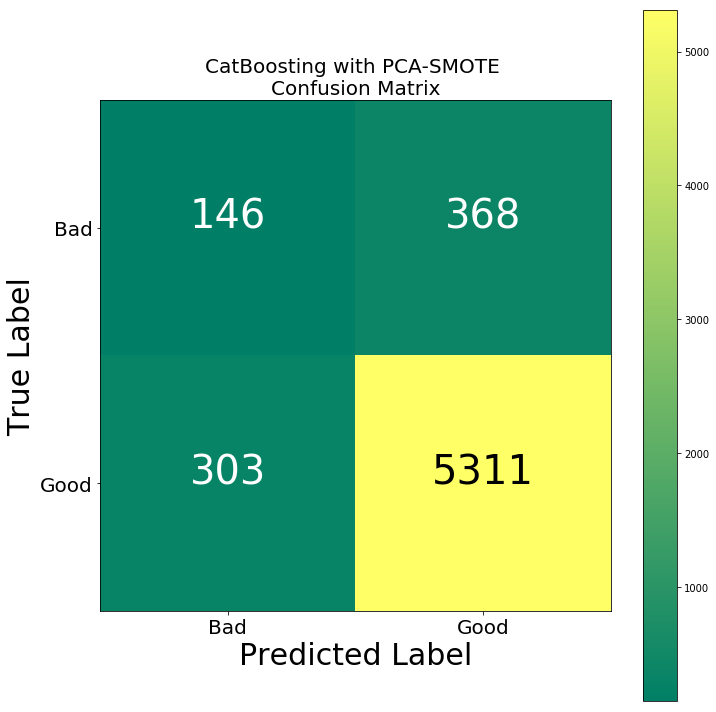

In [103]:
# Print confusion matrix for CatBoost 
disp_confusion_matrix(y_pred_pcasm_catboost, "CatBoosting", "PCA-SMOTE")

### 3.5 Comparison of PCA-SMOTE Models

In [104]:
comparison_table(y_preds = [y_pred_pcasm_logreg, y_pred_pcasm_rf, y_pred_pcasm_xgb, y_pred_pcasm_catboost], 
                 labels = ['LogReg', 'Random Forest', 'XGBoost', 'CatBoost'])

In [105]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with PCA & SMOTE\n')
df_tv2


Comparision Matrix of Modeling with PCA & SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.892461 bad       0.410161  0.643969  0.501136   
                                  good      0.965608  0.915212  0.939735   
                                  average   0.919019  0.892461  0.902946   
           Random Forest 0.906821 bad       0.164706  0.027237  0.046745   
                                  good      0.917260  0.987353  0.951017   
                                  average   0.854137  0.906821  0.875169   
           XGBoost       0.817885 bad       0.199000  0.387160  0.262880   
                                  good      0.938573  0.857321  0.896109   
                                  average   0.876539  0.817885  0.842995   
           CatBoost      0.890503 bad       0.325167  0.284047  0.303219   
                                  good      0.935200  0.946028  0.940583   
                                  average   0.884032  0.890503  0.887122   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.892461 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.906821 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.817885 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.890503 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

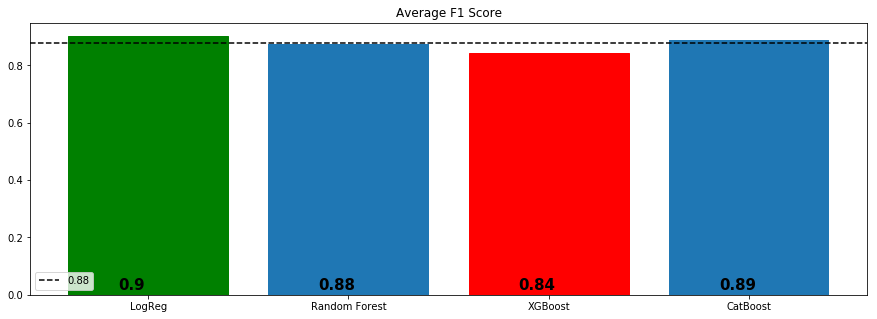

In [106]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 4. Truncated SVD + SMOTE

In [107]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(random_state=42)
svd_X_train = svd.fit_transform(count_vect_train)
svd_X_test = svd.transform(count_vect_test)

### SMOTE

In [108]:
sm = SMOTE(random_state=5)
df_ttext, df_ttarget = sm.fit_sample(svd_X_train, y_train)

print (df_ttext.shape)
print (df_ttarget.shape)

(33622, 2)
(33622,)


In [109]:
from collections import Counter
Counter(df_ttarget)

Counter({1: 16811, 0: 16811})

### 4.1 Logistic Regression

In [110]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_logreg = y_pred

f1 score: 0.7445336037682685


**Classification Report**


In [111]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_logreg))

              precision    recall  f1-score   support

           0       0.11      0.42      0.18       514
           1       0.93      0.70      0.80      5614

   micro avg       0.67      0.67      0.67      6128
   macro avg       0.52      0.56      0.49      6128
weighted avg       0.86      0.67      0.74      6128



**Confusion Matrix**

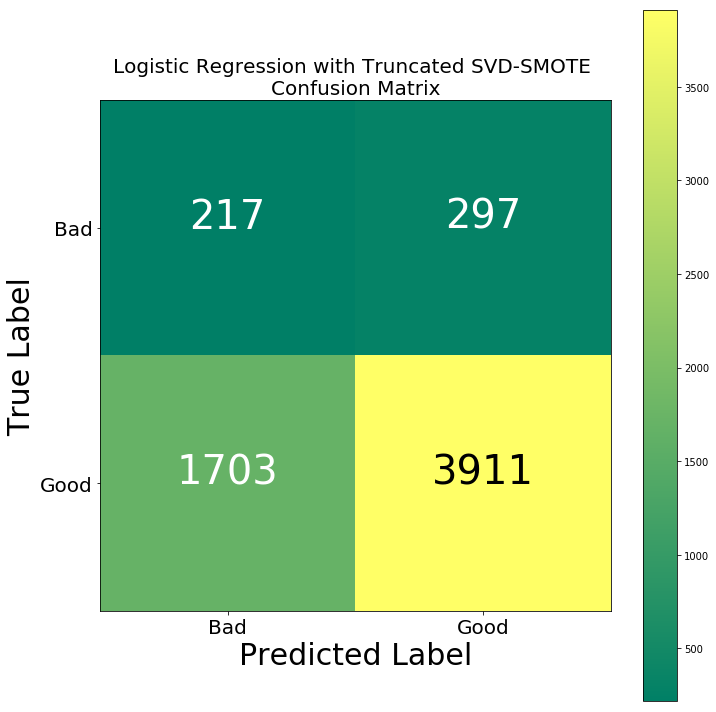

In [112]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_svd_logreg, "Logistic Regression", "Truncated SVD-SMOTE")

### 4.2 Random Forest

In [113]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_rf = y_pred

f1 score: 0.7641270030868983


**Classification Report**

In [114]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_rf))

              precision    recall  f1-score   support

           0       0.09      0.30      0.14       514
           1       0.92      0.74      0.82      5614

   micro avg       0.70      0.70      0.70      6128
   macro avg       0.51      0.52      0.48      6128
weighted avg       0.85      0.70      0.76      6128



**Confusion Matrix**

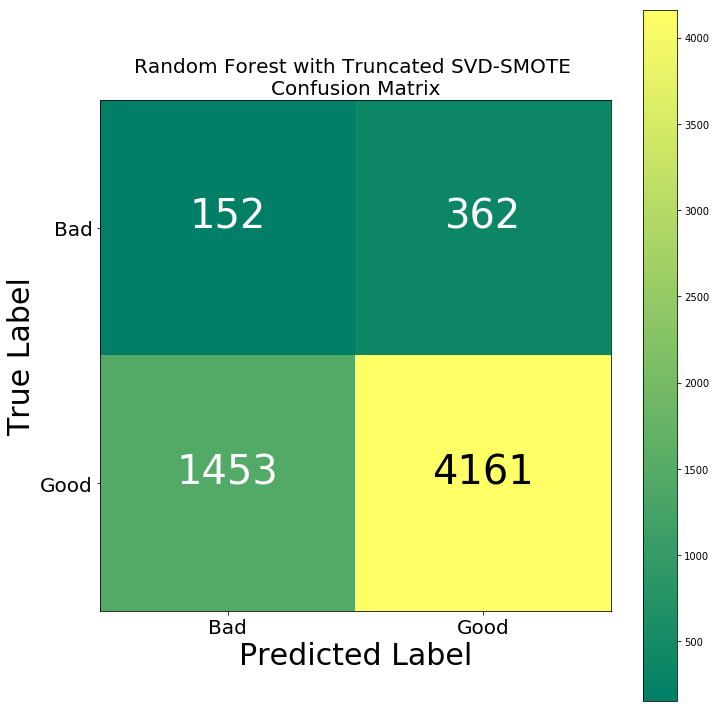

In [115]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_svd_rf, "Random Forest", "Truncated SVD-SMOTE")

### 4.3 XGBoost

In [116]:
# Call the modeling function for XGBoost and print f1 score
modeling(XGBClassifier(), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_xgb = y_pred

f1 score: 0.6055581937283437


**Classification Report**

In [117]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_xgb))

              precision    recall  f1-score   support

           0       0.11      0.67      0.18       514
           1       0.94      0.49      0.64      5614

   micro avg       0.50      0.50      0.50      6128
   macro avg       0.52      0.58      0.41      6128
weighted avg       0.87      0.50      0.61      6128



**Confusion Matrix**

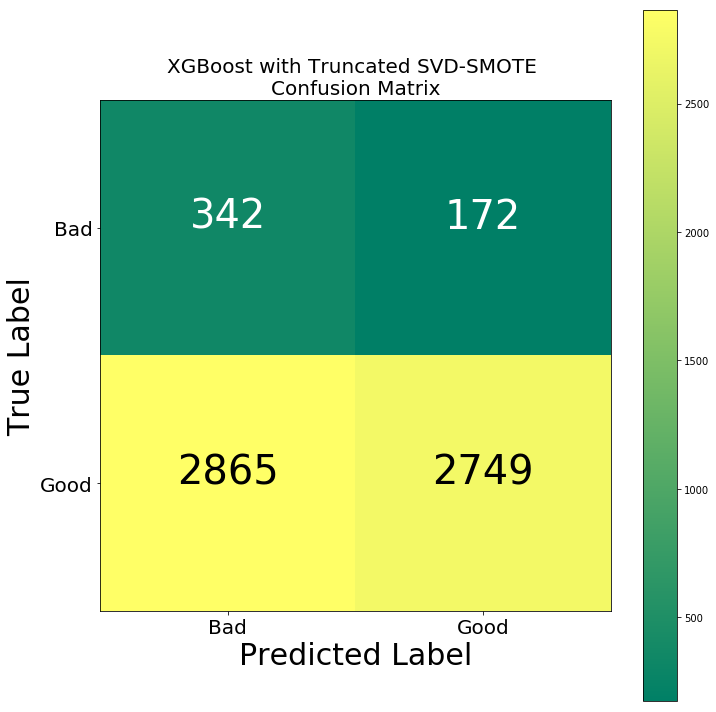

In [118]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_svd_xgb, "XGBoost", "Truncated SVD-SMOTE")

### 4.4 CatBoost

In [119]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_catboost = y_pred

0:	learn: 0.6859784	total: 21.9ms	remaining: 32.8s
1:	learn: 0.6831391	total: 47.3ms	remaining: 35.4s
2:	learn: 0.6793039	total: 70.9ms	remaining: 35.4s
3:	learn: 0.6787062	total: 91.6ms	remaining: 34.2s
4:	learn: 0.6767962	total: 113ms	remaining: 33.7s
5:	learn: 0.6757450	total: 132ms	remaining: 32.9s
6:	learn: 0.6748569	total: 154ms	remaining: 32.8s
7:	learn: 0.6747602	total: 174ms	remaining: 32.4s
8:	learn: 0.6734238	total: 193ms	remaining: 31.9s
9:	learn: 0.6724806	total: 214ms	remaining: 31.8s
10:	learn: 0.6714360	total: 250ms	remaining: 33.9s
11:	learn: 0.6710171	total: 274ms	remaining: 34s
12:	learn: 0.6707936	total: 292ms	remaining: 33.4s
13:	learn: 0.6704657	total: 310ms	remaining: 32.9s
14:	learn: 0.6698141	total: 334ms	remaining: 33.1s
15:	learn: 0.6691849	total: 355ms	remaining: 32.9s
16:	learn: 0.6686205	total: 372ms	remaining: 32.5s
17:	learn: 0.6683937	total: 394ms	remaining: 32.5s
18:	learn: 0.6681509	total: 412ms	remaining: 32.1s
19:	learn: 0.6680251	total: 435ms	remai

164:	learn: 0.6523117	total: 4.41s	remaining: 35.6s
165:	learn: 0.6522606	total: 4.43s	remaining: 35.6s
166:	learn: 0.6522308	total: 4.46s	remaining: 35.6s
167:	learn: 0.6521471	total: 4.49s	remaining: 35.6s
168:	learn: 0.6521103	total: 4.51s	remaining: 35.5s
169:	learn: 0.6520709	total: 4.52s	remaining: 35.4s
170:	learn: 0.6520652	total: 4.54s	remaining: 35.3s
171:	learn: 0.6518015	total: 4.57s	remaining: 35.3s
172:	learn: 0.6518015	total: 4.58s	remaining: 35.2s
173:	learn: 0.6517999	total: 4.6s	remaining: 35.1s
174:	learn: 0.6516980	total: 4.63s	remaining: 35.1s
175:	learn: 0.6516974	total: 4.65s	remaining: 35s
176:	learn: 0.6516947	total: 4.67s	remaining: 34.9s
177:	learn: 0.6516916	total: 4.69s	remaining: 34.8s
178:	learn: 0.6516868	total: 4.71s	remaining: 34.7s
179:	learn: 0.6516453	total: 4.73s	remaining: 34.7s
180:	learn: 0.6516314	total: 4.75s	remaining: 34.6s
181:	learn: 0.6516301	total: 4.77s	remaining: 34.5s
182:	learn: 0.6516235	total: 4.79s	remaining: 34.4s
183:	learn: 0.6

327:	learn: 0.6482553	total: 8.28s	remaining: 29.6s
328:	learn: 0.6482534	total: 8.31s	remaining: 29.6s
329:	learn: 0.6482530	total: 8.33s	remaining: 29.5s
330:	learn: 0.6482361	total: 8.36s	remaining: 29.5s
331:	learn: 0.6482177	total: 8.38s	remaining: 29.5s
332:	learn: 0.6482029	total: 8.4s	remaining: 29.4s
333:	learn: 0.6481350	total: 8.42s	remaining: 29.4s
334:	learn: 0.6481338	total: 8.44s	remaining: 29.4s
335:	learn: 0.6481215	total: 8.46s	remaining: 29.3s
336:	learn: 0.6481201	total: 8.48s	remaining: 29.3s
337:	learn: 0.6480278	total: 8.52s	remaining: 29.3s
338:	learn: 0.6480150	total: 8.54s	remaining: 29.3s
339:	learn: 0.6480092	total: 8.56s	remaining: 29.2s
340:	learn: 0.6480091	total: 8.59s	remaining: 29.2s
341:	learn: 0.6479518	total: 8.61s	remaining: 29.1s
342:	learn: 0.6479497	total: 8.63s	remaining: 29.1s
343:	learn: 0.6479496	total: 8.65s	remaining: 29.1s
344:	learn: 0.6479314	total: 8.67s	remaining: 29s
345:	learn: 0.6478003	total: 8.73s	remaining: 29.1s
346:	learn: 0.6

491:	learn: 0.6449913	total: 12.2s	remaining: 24.9s
492:	learn: 0.6449911	total: 12.2s	remaining: 24.9s
493:	learn: 0.6449881	total: 12.2s	remaining: 24.8s
494:	learn: 0.6449878	total: 12.2s	remaining: 24.8s
495:	learn: 0.6449856	total: 12.2s	remaining: 24.7s
496:	learn: 0.6449841	total: 12.2s	remaining: 24.7s
497:	learn: 0.6449834	total: 12.3s	remaining: 24.7s
498:	learn: 0.6449831	total: 12.3s	remaining: 24.6s
499:	learn: 0.6449827	total: 12.3s	remaining: 24.6s
500:	learn: 0.6449826	total: 12.3s	remaining: 24.6s
501:	learn: 0.6449821	total: 12.3s	remaining: 24.5s
502:	learn: 0.6449821	total: 12.3s	remaining: 24.5s
503:	learn: 0.6449820	total: 12.4s	remaining: 24.5s
504:	learn: 0.6449503	total: 12.4s	remaining: 24.4s
505:	learn: 0.6449502	total: 12.4s	remaining: 24.4s
506:	learn: 0.6449457	total: 12.4s	remaining: 24.3s
507:	learn: 0.6449452	total: 12.4s	remaining: 24.3s
508:	learn: 0.6449450	total: 12.5s	remaining: 24.3s
509:	learn: 0.6449431	total: 12.5s	remaining: 24.2s
510:	learn: 

652:	learn: 0.6427755	total: 15.3s	remaining: 19.9s
653:	learn: 0.6424928	total: 15.4s	remaining: 19.9s
654:	learn: 0.6424910	total: 15.4s	remaining: 19.8s
655:	learn: 0.6424903	total: 15.4s	remaining: 19.8s
656:	learn: 0.6424760	total: 15.4s	remaining: 19.8s
657:	learn: 0.6424540	total: 15.4s	remaining: 19.7s
658:	learn: 0.6424540	total: 15.5s	remaining: 19.7s
659:	learn: 0.6424513	total: 15.5s	remaining: 19.7s
660:	learn: 0.6424509	total: 15.5s	remaining: 19.7s
661:	learn: 0.6424113	total: 15.5s	remaining: 19.7s
662:	learn: 0.6424113	total: 15.5s	remaining: 19.6s
663:	learn: 0.6424005	total: 15.6s	remaining: 19.6s
664:	learn: 0.6424005	total: 15.6s	remaining: 19.6s
665:	learn: 0.6423991	total: 15.6s	remaining: 19.5s
666:	learn: 0.6423338	total: 15.6s	remaining: 19.5s
667:	learn: 0.6423335	total: 15.7s	remaining: 19.5s
668:	learn: 0.6423267	total: 15.7s	remaining: 19.5s
669:	learn: 0.6423254	total: 15.7s	remaining: 19.4s
670:	learn: 0.6423246	total: 15.7s	remaining: 19.4s
671:	learn: 

813:	learn: 0.6400597	total: 18.6s	remaining: 15.6s
814:	learn: 0.6400597	total: 18.6s	remaining: 15.6s
815:	learn: 0.6400016	total: 18.6s	remaining: 15.6s
816:	learn: 0.6400010	total: 18.6s	remaining: 15.6s
817:	learn: 0.6399983	total: 18.6s	remaining: 15.5s
818:	learn: 0.6399114	total: 18.6s	remaining: 15.5s
819:	learn: 0.6399095	total: 18.7s	remaining: 15.5s
820:	learn: 0.6399095	total: 18.7s	remaining: 15.5s
821:	learn: 0.6399087	total: 18.7s	remaining: 15.4s
822:	learn: 0.6399072	total: 18.7s	remaining: 15.4s
823:	learn: 0.6398992	total: 18.7s	remaining: 15.4s
824:	learn: 0.6398991	total: 18.8s	remaining: 15.4s
825:	learn: 0.6398991	total: 18.8s	remaining: 15.3s
826:	learn: 0.6398990	total: 18.8s	remaining: 15.3s
827:	learn: 0.6398984	total: 18.8s	remaining: 15.3s
828:	learn: 0.6398930	total: 18.8s	remaining: 15.2s
829:	learn: 0.6398929	total: 18.9s	remaining: 15.2s
830:	learn: 0.6398754	total: 18.9s	remaining: 15.2s
831:	learn: 0.6398688	total: 18.9s	remaining: 15.2s
832:	learn: 

974:	learn: 0.6386944	total: 21.7s	remaining: 11.7s
975:	learn: 0.6386944	total: 21.7s	remaining: 11.7s
976:	learn: 0.6386707	total: 21.8s	remaining: 11.7s
977:	learn: 0.6386705	total: 21.8s	remaining: 11.6s
978:	learn: 0.6386698	total: 21.9s	remaining: 11.6s
979:	learn: 0.6386692	total: 21.9s	remaining: 11.6s
980:	learn: 0.6386059	total: 21.9s	remaining: 11.6s
981:	learn: 0.6385836	total: 21.9s	remaining: 11.6s
982:	learn: 0.6385750	total: 21.9s	remaining: 11.5s
983:	learn: 0.6383961	total: 22s	remaining: 11.5s
984:	learn: 0.6383960	total: 22s	remaining: 11.5s
985:	learn: 0.6383934	total: 22s	remaining: 11.5s
986:	learn: 0.6383655	total: 22s	remaining: 11.4s
987:	learn: 0.6383605	total: 22s	remaining: 11.4s
988:	learn: 0.6383599	total: 22.1s	remaining: 11.4s
989:	learn: 0.6383587	total: 22.1s	remaining: 11.4s
990:	learn: 0.6383587	total: 22.1s	remaining: 11.3s
991:	learn: 0.6383583	total: 22.1s	remaining: 11.3s
992:	learn: 0.6383453	total: 22.1s	remaining: 11.3s
993:	learn: 0.6383407	

1134:	learn: 0.6376192	total: 24.9s	remaining: 8s
1135:	learn: 0.6376190	total: 24.9s	remaining: 7.98s
1136:	learn: 0.6376153	total: 24.9s	remaining: 7.96s
1137:	learn: 0.6375705	total: 24.9s	remaining: 7.93s
1138:	learn: 0.6375612	total: 25s	remaining: 7.91s
1139:	learn: 0.6375512	total: 25s	remaining: 7.89s
1140:	learn: 0.6375010	total: 25s	remaining: 7.87s
1141:	learn: 0.6375001	total: 25s	remaining: 7.84s
1142:	learn: 0.6375000	total: 25s	remaining: 7.82s
1143:	learn: 0.6374997	total: 25.1s	remaining: 7.8s
1144:	learn: 0.6374774	total: 25.1s	remaining: 7.77s
1145:	learn: 0.6374766	total: 25.1s	remaining: 7.75s
1146:	learn: 0.6374765	total: 25.1s	remaining: 7.73s
1147:	learn: 0.6374765	total: 25.1s	remaining: 7.7s
1148:	learn: 0.6374736	total: 25.1s	remaining: 7.68s
1149:	learn: 0.6374725	total: 25.2s	remaining: 7.66s
1150:	learn: 0.6374720	total: 25.2s	remaining: 7.63s
1151:	learn: 0.6374700	total: 25.2s	remaining: 7.61s
1152:	learn: 0.6374690	total: 25.2s	remaining: 7.59s
1153:	le

1295:	learn: 0.6358553	total: 28.3s	remaining: 4.45s
1296:	learn: 0.6358552	total: 28.3s	remaining: 4.43s
1297:	learn: 0.6358526	total: 28.3s	remaining: 4.41s
1298:	learn: 0.6358436	total: 28.3s	remaining: 4.38s
1299:	learn: 0.6358414	total: 28.4s	remaining: 4.36s
1300:	learn: 0.6358403	total: 28.4s	remaining: 4.34s
1301:	learn: 0.6358233	total: 28.4s	remaining: 4.32s
1302:	learn: 0.6358165	total: 28.4s	remaining: 4.3s
1303:	learn: 0.6358064	total: 28.5s	remaining: 4.28s
1304:	learn: 0.6358059	total: 28.5s	remaining: 4.25s
1305:	learn: 0.6358054	total: 28.5s	remaining: 4.23s
1306:	learn: 0.6358049	total: 28.5s	remaining: 4.21s
1307:	learn: 0.6358026	total: 28.5s	remaining: 4.19s
1308:	learn: 0.6358018	total: 28.6s	remaining: 4.17s
1309:	learn: 0.6358011	total: 28.6s	remaining: 4.14s
1310:	learn: 0.6358004	total: 28.6s	remaining: 4.12s
1311:	learn: 0.6357992	total: 28.6s	remaining: 4.1s
1312:	learn: 0.6357985	total: 28.6s	remaining: 4.08s
1313:	learn: 0.6356300	total: 28.7s	remaining: 4

1455:	learn: 0.6344527	total: 31.7s	remaining: 958ms
1456:	learn: 0.6344526	total: 31.7s	remaining: 936ms
1457:	learn: 0.6344525	total: 31.7s	remaining: 914ms
1458:	learn: 0.6344495	total: 31.8s	remaining: 892ms
1459:	learn: 0.6344493	total: 31.8s	remaining: 870ms
1460:	learn: 0.6343656	total: 31.8s	remaining: 849ms
1461:	learn: 0.6343637	total: 31.8s	remaining: 827ms
1462:	learn: 0.6343604	total: 31.8s	remaining: 805ms
1463:	learn: 0.6343564	total: 31.9s	remaining: 783ms
1464:	learn: 0.6343563	total: 31.9s	remaining: 762ms
1465:	learn: 0.6343562	total: 31.9s	remaining: 740ms
1466:	learn: 0.6343443	total: 31.9s	remaining: 718ms
1467:	learn: 0.6343435	total: 31.9s	remaining: 696ms
1468:	learn: 0.6343414	total: 32s	remaining: 675ms
1469:	learn: 0.6343241	total: 32s	remaining: 653ms
1470:	learn: 0.6343237	total: 32s	remaining: 631ms
1471:	learn: 0.6343228	total: 32s	remaining: 609ms
1472:	learn: 0.6343214	total: 32s	remaining: 587ms
1473:	learn: 0.6343210	total: 32.1s	remaining: 566ms
147

**Classification Report**

In [120]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_catboost))

              precision    recall  f1-score   support

           0       0.10      0.53      0.17       514
           1       0.93      0.56      0.70      5614

   micro avg       0.56      0.56      0.56      6128
   macro avg       0.51      0.55      0.44      6128
weighted avg       0.86      0.56      0.66      6128



**Confusion Matrix**

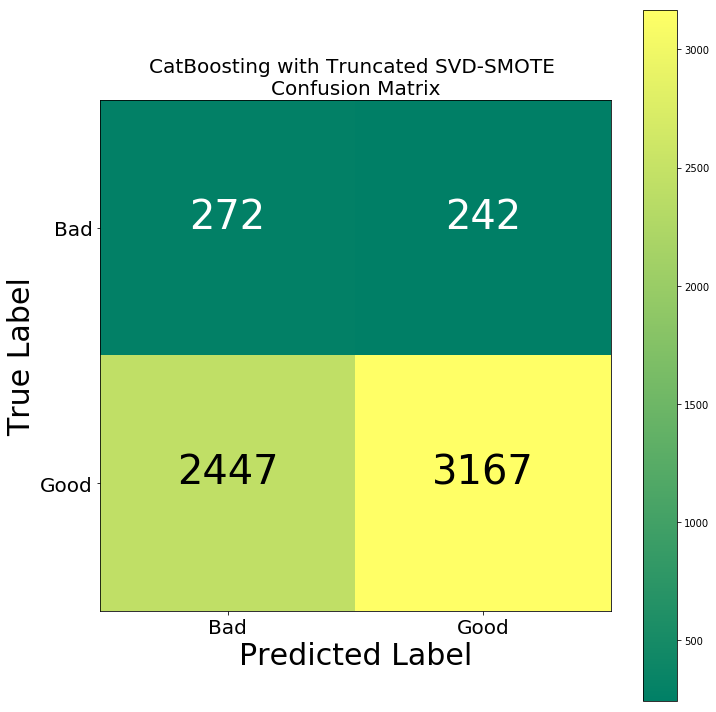

In [121]:
# Print confusion matrix for CatBoost 
disp_confusion_matrix(y_pred_svd_catboost, "CatBoosting", "Truncated SVD-SMOTE")

### 4.5 Comparison of Models

In [122]:
comparison_table(y_preds = [y_pred_svd_logreg, y_pred_svd_rf, y_pred_svd_xgb, y_pred_svd_catboost], 
                 labels = ['LogReg', 'Random Forest', 'XGBoost', 'CatBoost'])

In [123]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with SMOTE\n')
df_tv2


Comparision Matrix of Modeling with SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.673629 bad       0.113021  0.422179  0.178307   
                                  good      0.929420  0.696651  0.796375   
                                  average   0.860943  0.673629  0.744534   
           Random Forest 0.703819 bad       0.094704  0.295720  0.143464   
                                  good      0.919965  0.741183  0.820953   
                                  average   0.850744  0.703819  0.764127   
           XGBoost       0.504406 bad       0.106642  0.665370  0.183822   
                                  good      0.941116  0.489669  0.644171   
                                  average   0.871123  0.504406  0.605558   
           CatBoost      0.561195 bad       0.100037  0.529183  0.168265   
                                  good      0.929011  0.564125  0.701984   
                                  average   0.859479  0.561195  0.657217   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.673629 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.703819 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.504406 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.561195 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

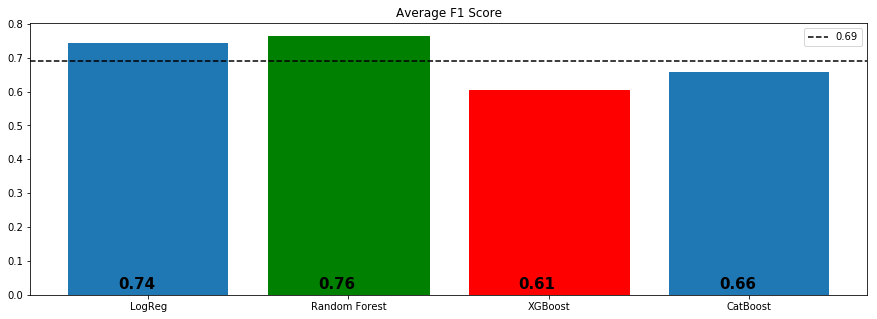

In [124]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")